# Pareto Frontier Analysis

## Overview
Multi-objective optimization for insurance decisions using Pareto frontiers.  We explore trade-offs between ROE, bankruptcy risk, and premium cost, identify knee-point solutions, and compare frontier generation methods.

- **Prerequisites**: [optimization/01_optimization_overview](01_optimization_overview.ipynb)
- **Estimated runtime**: 1-2 minutes
- **Audience**: [Practitioner] / [Developer]

In [24]:
"""Google Colab setup: mount Drive and install package dependencies.

Run this cell first. If prompted to restart the runtime, do so, then re-run all cells.
This cell is a no-op when running locally.
"""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization'

    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)

    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete. If you see numpy/scipy import errors below,')
    print('restart the runtime (Runtime > Restart runtime) and re-run all cells.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Setup complete. If you see numpy/scipy import errors below,
restart the runtime (Runtime > Restart runtime) and re-run all cells.


## Setup

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import multiprocessing

warnings.filterwarnings("ignore")

from ergodic_insurance.pareto_frontier import (
    Objective, ObjectiveType, ParetoFrontier, ParetoPoint,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = multiprocessing.cpu_count()
print(f"Number of CPU cores: {cores}")  # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

Number of CPU cores: 44


## Part I: Parameter Setup

### Configure Our Manufacturing Company

We model a volatile manufacturing company with the following characteristics:

| Parameter | Value | Why it matters |
|---|---|---|
| Total assets | \$5M | Sets the scale of risk (a single large loss can be existential) |
| Asset turnover | 2.0x | Revenue = Assets * turnover = ~\$10M |
| Operating margin | 15% | \$3M Operating income (the "cushion" for absorbing losses) |
| Revenue volatility | 15% | Operational asset uncertainty |
| Tax rate | 25% | Tax shield reduces net cost of both premiums and retained losses |
| Earnings retention | 70% | 70% of after-tax profit reinvested for growth |

In [26]:
# --- Economic Parameters
ATR = 2.0                # Asset turnover ratio
OPERATING_MARGIN = 0.15  # 12% EBIT margin before Insurable Losses
REV_VOL = 0.50           # Revenue volatility (annualized)
INITIAL_ASSETS = 5_000_000

# --- Company Configuration ---
mfg_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,          # $15M total assets
    asset_turnover_ratio=ATR,               # Revenue = Assets Ãƒâ€” turnover = $22.5M
    base_operating_margin=OPERATING_MARGIN, # 12% EBIT margin -> $2.7M/yr operating income
    tax_rate=0.25,                          # 25% corporate tax
    retention_ratio=0.70,                   # 70% earnings retained for growth
)

# Display company profile
revenue = mfg_config.initial_assets * mfg_config.asset_turnover_ratio
ebit = revenue * mfg_config.base_operating_margin
print("=" * 60)
print("MANUFACTURING COMPANY PROFILE")
print("=" * 60)
print(f"Total Assets:          ${mfg_config.initial_assets:>14,.0f}")
print(f"Annual Revenue:        ${revenue:>14,.0f}")
print(f"Operating Income:      ${ebit:>14,.0f}")
print(f"Operating Margin:      {mfg_config.base_operating_margin:>14.1%}")
print(f"Asset Turnover:        {mfg_config.asset_turnover_ratio:>14.1f}x")
print(f"Revenue Volatility:    {REV_VOL:>14}")
print(f"Tax Rate:              {mfg_config.tax_rate:>13.1%}")
print(f"Retention Ratio:       {mfg_config.retention_ratio:>13.1%}")
print("=" * 60)

MANUFACTURING COMPANY PROFILE
Total Assets:          $     5,000,000
Annual Revenue:        $    10,000,000
Operating Income:      $     1,500,000
Operating Margin:               15.0%
Asset Turnover:                   2.0x
Revenue Volatility:               0.5
Tax Rate:                      25.0%
Retention Ratio:               70.0%


<a id="part3"></a>
### The 4-Layer Insurance Program

A realistic commercial insurance program is built in **layers** that stack on top of each other:

```
                                          $100M  +-------------------+
                                                 |  Layer 4: CAT     |
                                                 |  $50M xs $50M     |
                                                 |  Rate: 0.2%       |
                                          $50M   +-------------------+
                                                 |  Layer 3: 2nd Xs  |
                                                 |  $25M xs $25M     |
                                                 |  Rate: 0.4%       |
                                          $25M   +-------------------+
                                                 |  Layer 2: 1st Xs  |
                                                 |  $20M xs $5M      |
                                                 |  Rate: 0.8%       |
                                          $5M    +-------------------+
                                                 |  Layer 1: Primary |
                                                 |  $4.75M xs $250K  |
                                                 |  Rate: 1.5%       |
                                          $250K  +-------------------+
                                                 | Deductible        |
                                          $0     |                   |
                                                 +-------------------+
```

How losses flow through the tower:

- **Losses below \$250K**: Company pays in full (deductible)
- **Losses \$250K - \$5M**: Layer 1 (Primary) responds -- this is the "working layer" with frequent claims
- **Losses \$5M - \$25M**: Layer 2 (1st Excess) picks up the excess
- **Losses \$25M - \$50M**: Layer 3 (2nd Excess) -- infrequent severe losses
- **Losses \$50M - \$100M**: Layer 4 (Catastrophic) -- rare but devastating events
- **Losses above \$100M**: Uninsured -- company bears full exposure

The premium rate (rate-on-line) decreases as you go higher because the probability of reaching that layer drops dramatically.

In [27]:
def create_insurance_program(retention_factor=1.0, limit_factor=1.0):
    """Create a 4-layer manufacturing insurance program.

    Rate-on-line will be tuned later in the simulation.

    Args:
        retention_factor: Multiplier on all attachment points (for optimization).
        limit_factor: Multiplier on all limits (for optimization).
    """
    layers = [
        # Layer 1: Primary (working layer)
        EnhancedInsuranceLayer(
            attachment_point=250_000 * retention_factor,
            limit=(5_000_000 - 250_000) * limit_factor,
            base_premium_rate=0.38,   # 38% rate-on-line (working layer)
            reinstatements=0,
        ),
        # Layer 2: First Excess
        EnhancedInsuranceLayer(
            attachment_point=5_000_000 * retention_factor,
            limit=20_000_000 * limit_factor,
            base_premium_rate=0.015,  # 1.5% rate-on-line
            reinstatements=1,
        ),
        # Layer 3: Second Excess
        EnhancedInsuranceLayer(
            attachment_point=25_000_000 * retention_factor,
            limit=25_000_000 * limit_factor,
            base_premium_rate=0.005,  # 0.5% rate-on-line
            reinstatements=2,
        ),
        # Layer 4: Catastrophic
        EnhancedInsuranceLayer(
            attachment_point=50_000_000 * retention_factor,
            limit=50_000_000 * limit_factor,
            base_premium_rate=0.002,  # 0.2% rate-on-line
            reinstatements=999,        # Effectively unlimited
        ),
    ]
    return InsuranceProgram(
        layers=layers,
        deductible=250_000 * retention_factor,
        name="Manufacturing 4-Layer Program",
    )


# Create baseline program
program = create_insurance_program()
summary = program.get_program_summary()

print("4-LAYER INSURANCE PROGRAM")
print("=" * 70)
print(f"{'Layer':<12} {'Attachment':>12} {'Limit':>12} {'Exhaust Pt':>12} {'Premium':>10}")
print("-" * 70)
for i, layer_info in enumerate(summary['layers']):
    print(f"Layer {i+1:<5}  ${layer_info['attachment']:>11,.0f} ${layer_info['limit']:>11,.0f} "
          f"${layer_info['exhaustion_point']:>11,.0f} ${layer_info['base_premium']:>9,.0f}")
print("-" * 70)
print(f"{'TOTAL':<12} {'':>12} {'':>12} {'':>12} ${summary['annual_base_premium']:>9,.0f}")
print(f"\nDeductible: ${summary['deductible']:,.0f}")
print(f"Total Coverage: ${summary['total_coverage']:,.0f}")

4-LAYER INSURANCE PROGRAM
Layer          Attachment        Limit   Exhaust Pt    Premium
----------------------------------------------------------------------
Layer 1      $    250,000 $  4,750,000 $  5,000,000 $1,805,000
Layer 2      $  5,000,000 $ 20,000,000 $ 25,000,000 $  300,000
Layer 3      $ 25,000,000 $ 25,000,000 $ 50,000,000 $  125,000
Layer 4      $ 50,000,000 $ 50,000,000 $100,000,000 $  100,000
----------------------------------------------------------------------
TOTAL                                               $2,330,000

Deductible: $250,000
Total Coverage: $99,750,000


### Shared Simulation Infrastructure

The cell below sets up four things used by every subsequent section:

1. **Amplified loss model** using the library's `ManufacturingLossGenerator` -- calibrated so the \$15M company faces significant expected annual losses relative to operating income, creating genuine existential risk.
2. **Analytical layer pricing** using the library's `LayerPricer` to compute actuarially sound premiums from the known severity distributions via limited expected values (LEVs). Rate-on-line adjusts naturally with retention: higher Ded at lower primary-layer ROL, producing the genuine cost-vs-variance tradeoff the HJB solver needs.
3. **Common Random Numbers (CRN)** -- pre-generated loss scenarios at a fixed reference revenue. Every strategy faces the *same storms*; the only difference is how each ship is built. Loss amounts are then **scaled by the square root of revenue** so that a growing company faces proportionally growing risks, keeping the economics consistent between insured and uninsured strategies.
4. **CRN simulation engine** -- processes scaled pre-generated losses through the library's `InsuranceProgram.process_claim()`, so retained losses are calculated correctly by the insurance tower. Premium is repriced at actual revenue with the same square-root scaling.

> **"Same storms, different ships."** By fixing the loss scenarios across strategies, even small differences in time-average growth become statistically significant. Without CRN, you would need 10x more paths to detect the same signal.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import (
    ManufacturingLossGenerator, LognormalLoss, ParetoLoss,
)
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

# =====================================================
# SHARED SIMULATION INFRASTRUCTURE
# =====================================================
# Used by Parts 5, 8, 9, 10, and 11.

# --- Economic Parameters ---
REFERENCE_REVENUE = ATR * INITIAL_ASSETS  # Fixed reference for loss calibration

# --- Loss Scaling ---
# Loss frequency (and CRN loss amounts) scale with the square root of
# revenue.  This keeps the loss drag proportional to the company's
# actual size for both insured and uninsured strategies.
FREQ_SCALING_EXPONENT = 0.75

# --- Amplified Loss Model ---
ATTR_BASE_FREQ = 5
ATTR_SEV_MEAN = 10_000
ATTR_SEV_CV = 10

LG_BASE_FREQ = 1.75
LG_SEV_MEAN = 400_000
LG_SEV_CV = 5

CAT_BASE_FREQ = 0.25
CAT_SEV_ALPHA = 2.01
CAT_SEV_XM = 800_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ,
                        'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV,
                        'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ,
                  'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV,
                  'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ,
                         'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM,
                         'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# Quick validation of the loss model
_val_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=99)
_val_totals = []
SCENARIOS = 10_000
for _ in range(SCENARIOS):
    _events, _stats = _val_gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    _val_totals.append(_stats['total_amount'])
_expected_annual_loss = np.mean(_val_totals)
_operating_income = INITIAL_ASSETS * ATR * OPERATING_MARGIN
print(f"Loss model validation ({SCENARIOS:,.0f} one-year samples):")
print(f"  Expected annual loss:  ${_expected_annual_loss:>12,.0f}")
print(f"  Operating income:      ${_operating_income:>12,.0f}")
print(f"  Loss / Income ratio:   {_expected_annual_loss / _operating_income:.0%}")
print(f"  Std dev annual loss:   ${np.std(_val_totals):>12,.0f}")
print(f"  Max annual loss:       ${np.max(_val_totals):>12,.0f}")
del _val_gen, _val_totals, _events, _stats


# --- Analytical Layer Pricing via LEV ---
# Instead of hardcoded rate-on-line values, we compute actuarially sound
# premiums from the known severity distributions using limited expected
# values (LEVs).  For each layer (attachment a, limit l):
#
#   E[layer loss] = sum_i  freq_i * [LEV_i(a+l) - LEV_i(a)]
#   premium       = E[layer loss] / target_loss_ratio
#   rate_on_line  = premium / limit
#
# This ensures the primary-layer ROL decreases naturally as the Ded
# (retention) rises, producing the genuine cost-vs-variance tradeoff
# that the HJB solver needs.
#
# The pricers are parameterized so that the sensitivity analysis (Part 9)
# can adapt premiums to match the modified loss assumptions being tested.

TARGET_LOSS_RATIO = 0.85  # Soft-market loss ratio

def make_layer_pricers(large_freq=LG_BASE_FREQ,
                       large_sev_mean=LG_SEV_MEAN,
                       cur_revenue=REFERENCE_REVENUE):
    """Create a tuple of LayerPricers for a given loss parameterization.

    Frequency scales as (revenue / reference)^0.5, matching the loss
    model's sub-linear revenue scaling.  This keeps premium and loss
    scaling consistent so that insured and uninsured strategies face
    the same proportional cost growth.

    Args:
        large_freq: Large-loss annual frequency (default 1.0).
        large_sev_mean: Large-loss mean severity (default $1M).
        cur_revenue: Current revenue for frequency scaling.

    Returns:
        Tuple of (attritional, large, catastrophic) LayerPricers.
    """
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=large_sev_mean, cv=LG_SEV_CV),
                    frequency=large_freq * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )


# Default pricers for baseline loss model
DEFAULT_PRICERS = make_layer_pricers()


def analytical_layer_premium(attachment: float, limit: float,
                             pricers=None) -> float:
    """Compute actuarial premium for a layer using LEV-based expected losses.

    Premium = E[layer loss] / target_loss_ratio, where:
      E[layer loss] = sum over components of freq_i * (LEV_i(a+l) - LEV_i(a))

    Args:
        attachment: Layer attachment point.
        limit: Layer limit (width of coverage).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.
    """
    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    return expected_loss / TARGET_LOSS_RATIO


def analytical_rate_on_line(attachment: float, limit: float,
                            pricers=None) -> float:
    """Compute rate-on-line for a layer: premium / limit."""
    if limit <= 0:
        return 0.0
    return analytical_layer_premium(attachment, limit, pricers) / limit


# Validate: show how ROL varies across sample attachment points
print(f"\nAnalytical layer pricing (target LR = {TARGET_LOSS_RATIO:.0%}):")
print(f"  {'Attachment':>12s}  {'Limit':>12s}  {'E[Loss]':>12s}  {'Premium':>12s}  {'ROL':>8s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*8}")
for _a, _l in [(10_000, 4_990_000), (25_000, 4_975_000), (50_000, 4_950_000),
               (250_000, 4_750_000), (1_000_000, 4_000_000),
               (2_000_000, 3_000_000), (4_000_000, 1_000_000),
               (5_000_000, 20_000_000), (25_000_000, 25_000_000), (50_000_000, 50_000_000)]:
    _el = analytical_layer_premium(_a, _l) * TARGET_LOSS_RATIO
    _p = analytical_layer_premium(_a, _l)
    _r = analytical_rate_on_line(_a, _l)
    print(f"  ${_a:>11,.0f}  ${_l:>11,.0f}  ${_el:>11,.0f}  ${_p:>11,.0f}  {_r:>7.2%}")


# --- Insurance Tower Factory ---
# Premium rates are computed analytically from the loss distribution,
# ensuring that the primary-layer ROL decreases with higher retention.
# The optional `pricers` argument lets the sensitivity analysis pass
# in LayerPricers built from alternative loss assumptions, so that
# premiums stay consistent with the loss environment being tested.

def make_program(ded: float, pricers=None) -> InsuranceProgram:
    """Create 4-layer tower with analytically priced premiums.

    Uses LEV-based layer pricing from severity distributions so that
    rate-on-line adjusts naturally with the retention level.

    Args:
        ded: Deductible.
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.

    Returns:
        InsuranceProgram with actuarially sound premium loading.
    """
    layer_defs = [
        # (base_attachment, ceiling, reinstatements)
        (ded,        5_000_000,   0),     # Primary (working layer)
        (5_000_000,  25_000_000,  1),     # 1st Excess
        (25_000_000, 50_000_000,  2),     # 2nd Excess
        (50_000_000, 100_000_000, 999),   # Cat
    ]
    layers = []
    for attach, ceiling, reinst in layer_defs:
        effective_attach = max(attach, ded)
        limit = ceiling - effective_attach
        if limit <= 0:
            continue
        rol = analytical_rate_on_line(effective_attach, limit, pricers)
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rol,
            reinstatements=reinst,
        ))
    return InsuranceProgram(
        layers=layers,
        deductible=ded,
        name=f"Manufacturing Tower (Ded=${ded:,.0f})",
    )


# --- CRN: Pre-generate Loss Scenarios ---
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED):
    """Pre-generate loss scenarios for Common Random Number comparison.

    All strategies will face the exact same loss events and revenue shocks.
    Losses are generated at a fixed reference revenue; the simulation
    engine then scales event amounts by (actual_revenue / reference)^0.5
    so that loss burden grows proportionally with the company.
    """
    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)

    # Shared revenue shocks
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))

    # Per-path loss event sequences
    all_losses = []  # [path][year] -> List[LossEvent]
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(
            **LOSS_PARAMS,
            seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
        )
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)

    return revenue_shocks, all_losses


# --- CRN Simulation Engine ---
def simulate_with_crn(ded, revenue_shocks, loss_pool, n_years=1,
                      initial_assets=INITIAL_ASSETS, pricers=None):
    """Simulate one static-Ded strategy across all CRN paths.

    Uses the library's InsuranceProgram.process_claim() to correctly
    allocate each loss through the insurance tower.

    Loss amounts from the CRN pool are scaled by
    (actual_revenue / REFERENCE_REVENUE)^FREQ_SCALING_EXPONENT so that
    the loss burden grows proportionally with the company.  Premium is
    repriced at actual revenue with the same exponent, keeping the
    cost-of-risk consistent between insured and uninsured strategies.

    Args:
        ded: Deductible.
        revenue_shocks: Pre-generated revenue shocks (n_paths x n_years).
        loss_pool: Pre-generated loss events [path][year] -> List[LossEvent].
        n_years: Simulation horizon.
        initial_assets: Starting wealth.
        pricers: Tuple of LayerPricers for premium calculation.
            Uses DEFAULT_PRICERS if None (baseline loss assumptions).

    Returns:
        paths: array of shape (n_paths, n_years + 1) with asset values.
    """
    n_paths = len(loss_pool)
    paths = np.zeros((n_paths, n_years + 1))
    paths[:, 0] = initial_assets

    # Build program template and get fixed annual premium
    if ded >= 100_000_000:
        # "No insurance" -- skip tower entirely
        annual_premium = 0.0
        use_insurance = False
        program_template = None
    else:
        program_template = make_program(ded, pricers=pricers)
        annual_premium = program_template.calculate_premium()
        use_insurance = True

    for i in range(n_paths):
        assets = initial_assets
        for t in range(n_years):
            # Operating income with shared revenue shock
            revenue = assets * ATR * np.exp(
                REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
            )
            operating_income = revenue * OPERATING_MARGIN

            # Scale CRN losses to current revenue (sqrt scaling)
            loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

            # Process losses through insurance tower
            total_retained = 0.0
            if use_insurance:
                new_pricers = make_layer_pricers(cur_revenue=revenue)
                program_update = make_program(ded, pricers=new_pricers)
                annual_premium = program_update.calculate_premium()
                program = InsuranceProgram.create_fresh(program_update)
                for event in loss_pool[i][t]:
                    scaled_amount = event.amount * loss_scale
                    result = program.process_claim(scaled_amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in loss_pool[i][t]:
                    total_retained += event.amount * loss_scale

            # Net income and asset update
            assets = assets + operating_income - total_retained - annual_premium
            assets = max(assets, 0.0)
            paths[i, t + 1] = assets

    return paths


# Pre-generate the main CRN pool
N_PATHS = 50_000
N_YEARS = 1
print(f"\nPre-generating CRN loss pool ({N_PATHS:,.0f} paths x {N_YEARS} years)...")
t0 = time.time()
CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(n_paths=N_PATHS, n_years=N_YEARS)
print(f"  Done in {time.time() - t0:.1f}s")
print(f"  Shape: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

# Quick sanity: total losses per path-year
_annual_totals = [
    sum(e.amount for e in CRN_LOSSES[i][t])
    for i in range(N_PATHS) for t in range(N_YEARS)
]
print(f"  Mean annual loss: ${np.mean(_annual_totals):,.0f}")
del _annual_totals

Loss model validation (10,000 one-year samples):
  Expected annual loss:  $   1,140,707
  Operating income:      $   1,500,000
  Loss / Income ratio:   76%
  Std dev annual loss:   $   2,329,126
  Max annual loss:       $  70,845,147

Analytical layer pricing (target LR = 85%):
    Attachment         Limit       E[Loss]       Premium       ROL
  ------------  ------------  ------------  ------------  --------
  $     10,000  $  4,990,000  $    959,675  $  1,129,029   22.63%
  $     25,000  $  4,975,000  $    927,801  $  1,091,530   21.94%
  $     50,000  $  4,950,000  $    886,712  $  1,043,191   21.07%
  $    250,000  $  4,750,000  $    691,064  $    813,017   17.12%
  $  1,000,000  $  4,000,000  $    325,441  $    382,871    9.57%
  $  2,000,000  $  3,000,000  $    150,938  $    177,574    5.92%
  $  4,000,000  $  1,000,000  $     29,996  $     35,289    3.53%
  $  5,000,000  $ 20,000,000  $    122,074  $    143,617    0.72%
  $ 25,000,000  $ 25,000,000  $     18,616  $     21,901   

## Part II - Objective Evaluation

### Bi-Objective: Ergodic Growth vs. Ruin Risk

We sweep the deductible from **\$0** (full guaranteed cost) to **\$50M** (complete retention), evaluating each strategy against the same 10,000 CRN loss scenarios from Part I.

| Objective | Direction | What it measures |
|---|---|---|
| **Ergodic growth rate** | Maximize | $g = E[\ln(W_T/W_0)]$ — the time-average growth exponent |
| **Ruin probability** | Minimize | $P(W_T \leq 0)$ — probability of bankruptcy within one year |

**Low Ded** → expensive premium drags growth, but near-zero ruin.  
**High Ded** → zero premium, but catastrophic losses destroy compounding.  
The Pareto frontier reveals which retention levels offer efficient trade-offs — and which are strictly dominated.

In [29]:
ded_grid = np.unique(np.concatenate([
    [0, 10_000, 15_000, 25_000, 50_000, 75_000,
     100_000, 125_000, 150_000, 175_000, 200_000, 250_000,
     300_000, 350_000, 400_000, 450_000, 500_000, 750_000, 1_000_000,
     1_250_000, 1_500_000, 1_750_000, 2_000_000, 2_500_000,
     3_000_000, 3_500_000, 4_000_000, 4_500_000,
     5_000_000, 7_500_000, 10_000_000, 15_000_000,
     20_000_000, 25_000_000, 30_000_000, 35_000_000,
     40_000_000, 45_000_000, 50_000_000],  # landmarks
    np.geomspace(50_000_000, 100_000_000, 20)[1:], # excess range
]))

print(f"Sweeping {len(ded_grid)} Ded values x {N_PATHS:,} CRN paths across {N_CORES} cores...\n")
t0 = time.time()

# Helper function for parallel execution
def _run_single_ded_simulation(ded_value):
    """Simulates one Ded strategy and calculates its objectives."""
    paths = simulate_with_crn(ded_value, CRN_SHOCKS, CRN_LOSSES, n_years=N_YEARS)
    W_T = paths[:, -1]

    g    = np.mean(np.log(np.maximum(W_T, 1.0) / INITIAL_ASSETS))
    ruin = np.mean(W_T <= 0)

    prem = 0.0
    if ded_value < 100_000_000:
        # Make sure make_program is accessible in the worker process
        program_instance = make_program(ded_value)
        prem = program_instance.calculate_premium()

    record = dict(
        ded=ded_value, growth_rate=g, ruin_prob=ruin, premium=prem,
        mean_wealth=np.mean(W_T), median_wealth=np.median(W_T),
        std_wealth=np.std(W_T),
        p10=np.percentile(W_T, 10), p90=np.percentile(W_T, 90),
    )
    return ded_value, record, W_T

records = []
wealth_pool = {}   # ded -> terminal wealth array (for distribution plots)

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor(max_workers=N_CORES) as executor:
    # Use map to run _run_single_ded_simulation for each ded in ded_grid
    # The map method returns results in the order the inputs were submitted.
    results = list(executor.map(_run_single_ded_simulation, ded_grid))

# Process results after all computations are done
for k, (ded, record, W_T) in enumerate(results):
    records.append(record)
    wealth_pool[ded] = W_T
    print(f"  [{k+1:>3d}/{len(ded_grid)}]  Ded=${ded:>13,.0f}  g={record['growth_rate']:>+.4f}  " \
          f"P(ruin)={record['ruin_prob']:.2%}  Premium=${record['premium']:>10,.0f}")

df_grid = pd.DataFrame(records)
elapsed = time.time() - t0
print(f"\nDone in {elapsed:.0f}s")

# Derived metrics
E_oper = INITIAL_ASSETS * ATR * OPERATING_MARGIN
df_grid['tcor'] = E_oper - (df_grid['mean_wealth'] - INITIAL_ASSETS)

# Optimal Ded (peak ergodic growth)
opt_idx = df_grid['growth_rate'].idxmax()
opt_ded = df_grid.loc[opt_idx, 'ded']
opt_g   = df_grid.loc[opt_idx, 'growth_rate']
print(f"\n>>>  Optimal Ded = ${opt_ded:,.0f}   (g = {opt_g:+.4f})")

# ---- Interpolation-backed objective function for ParetoFrontier ----
_s, _g, _r, _p = [df_grid[c].values for c in ('ded', 'growth_rate', 'ruin_prob', 'premium')]

def sim_objectives(x):
    """Interpolated CRN objectives (instant evaluation for optimizers)."""
    ded = float(np.clip(x[0], _s[0], _s[-1]))
    return {
        'growth_rate': float(np.interp(ded, _s, _g)),
        'ruin_prob':   float(np.interp(ded, _s, _r)),
        'premium':     float(np.interp(ded, _s, _p)),
    }

# ---- Bi-objective Pareto frontier: growth vs ruin ----
objectives_2d = [
    Objective("growth_rate", ObjectiveType.MAXIMIZE, weight=0.5),
    Objective("ruin_prob",   ObjectiveType.MINIMIZE, weight=0.5),
]
frontier_2d = ParetoFrontier(
    objectives=objectives_2d,
    objective_function=sim_objectives,
    bounds=[(0, 100_000_000)],
    seed=SEED,
)

all_pts = [
    ParetoPoint(
        objectives={'growth_rate': r['growth_rate'], 'ruin_prob': r['ruin_prob']},
        decision_variables=np.array([r['ded']]),
    )
    for r in records
]
frontier_2d.frontier_points = frontier_2d._filter_dominated_points(all_pts)
frontier_2d._calculate_crowding_distances()
frontier_2d._calculate_trade_offs()

print(f"Pareto frontier: {len(frontier_2d.frontier_points)} non-dominated "
      f"of {len(all_pts)} evaluated")

Sweeping 58 Ded values x 50,000 CRN paths across 40 cores...

  [  1/58]  Ded=$            0  g=+0.0344  P(ruin)=0.00%  Premium=$ 1,343,705
  [  2/58]  Ded=$       10,000  g=+0.0354  P(ruin)=0.00%  Premium=$ 1,304,830
  [  3/58]  Ded=$       15,000  g=+0.0357  P(ruin)=0.00%  Premium=$ 1,291,111
  [  4/58]  Ded=$       25,000  g=+0.0363  P(ruin)=0.00%  Premium=$ 1,267,331
  [  5/58]  Ded=$       50,000  g=+0.0376  P(ruin)=0.00%  Premium=$ 1,218,992
  [  6/58]  Ded=$       75,000  g=+0.0386  P(ruin)=0.00%  Premium=$ 1,179,232
  [  7/58]  Ded=$      100,000  g=+0.0394  P(ruin)=0.00%  Premium=$ 1,144,591
  [  8/58]  Ded=$      125,000  g=+0.0400  P(ruin)=0.00%  Premium=$ 1,113,501
  [  9/58]  Ded=$      150,000  g=+0.0406  P(ruin)=0.00%  Premium=$ 1,085,071
  [ 10/58]  Ded=$      175,000  g=+0.0411  P(ruin)=0.00%  Premium=$ 1,058,731
  [ 11/58]  Ded=$      200,000  g=+0.0415  P(ruin)=0.00%  Premium=$ 1,034,087
  [ 12/58]  Ded=$      250,000  g=+0.0422  P(ruin)=0.00%  Premium=$   988,818
  

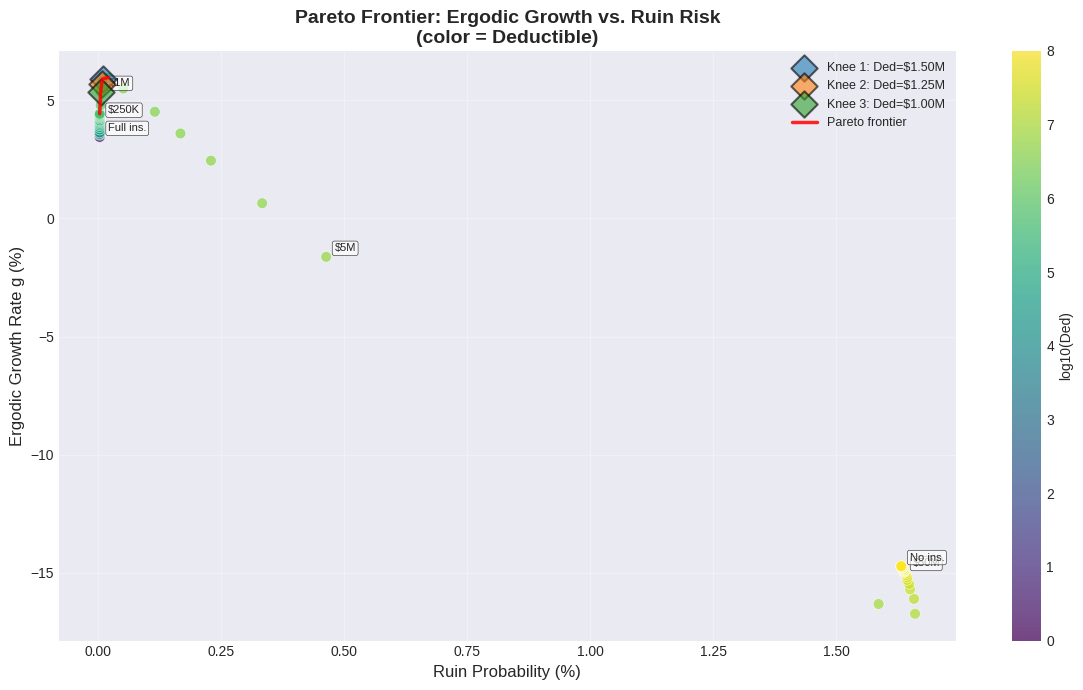

KNEE POINTS -- Optimal Compromise Solutions

  Knee 1:  Ded = $   1,500,000
    Ergodic growth g  = +0.0590  (+5.90%)
    Ruin probability  = 0.01%
    Annual premium    = $     429,566  (29% of EBIT)
    Median wealth     = $   5,437,339

  Knee 2:  Ded = $   1,250,000
    Ergodic growth g  = +0.0569  (+5.69%)
    Ruin probability  = 0.01%
    Annual premium    = $     484,158  (32% of EBIT)
    Median wealth     = $   5,402,674

  Knee 3:  Ded = $   1,000,000
    Ergodic growth g  = +0.0535  (+5.35%)
    Ruin probability  = 0.01%
    Annual premium    = $     558,672  (37% of EBIT)
    Median wealth     = $   5,362,057


In [30]:
knee_pts = frontier_2d.get_knee_points(n_knees=3)

fig, ax = plt.subplots(figsize=(12, 7))

# All evaluated points, colored by Ded
scat = ax.scatter(
    df_grid['ruin_prob'] * 100, df_grid['growth_rate'] * 100,
    c=np.log10(df_grid['ded'].clip(lower=1)), cmap='viridis',
    s=60, alpha=0.7, edgecolors='w', linewidth=0.5, zorder=3,
)
plt.colorbar(scat, ax=ax, label='log10(Ded)')

# Knee points
for i, kp in enumerate(knee_pts, 1):
    sv = kp.decision_variables[0]
    lbl = f"${sv/1e6:.2f}M" if sv >= 1e6 else f"${sv/1e3:.0f}K"
    ax.scatter(kp.objectives['ruin_prob'] * 100, kp.objectives['growth_rate'] * 100,
               s=180, marker='D', edgecolors='k', linewidth=1.5, zorder=4,
               label=f'Knee {i}: Ded={lbl}', alpha=0.6)

# Pareto frontier line
fdf = frontier_2d.to_dataframe().sort_values('ruin_prob')
ax.plot(fdf['ruin_prob'] * 100, fdf['growth_rate'] * 100,
        'r-', lw=2.5, alpha=0.85, label='Pareto frontier', zorder=5)

# Annotate landmark Ded values
landmarks = {0: 'Full ins.', 250_000: '$250K', 1_000_000: '$1M',
             5_000_000: '$5M', 50_000_000: '$50M', 100_000_000: 'No ins.'}
for target, tag in landmarks.items():
    idx = (df_grid['ded'] - target).abs().argmin()
    row = df_grid.iloc[idx]
    ax.annotate(tag, (row['ruin_prob'] * 100, row['growth_rate'] * 100),
                fontsize=8, ha='left', xytext=(6, 4), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, lw=0.5))

ax.set_xlabel('Ruin Probability (%)', fontsize=12)
ax.set_ylabel('Ergodic Growth Rate g (%)', fontsize=12)
ax.set_title('Pareto Frontier: Ergodic Growth vs. Ruin Risk\n'
             '(color = Deductible)',
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Knee-point details
print("=" * 72)
print("KNEE POINTS -- Optimal Compromise Solutions")
print("=" * 72)
for i, kp in enumerate(knee_pts, 1):
    sv = kp.decision_variables[0]
    row = df_grid.iloc[(df_grid['ded'] - sv).abs().argmin()]
    print(f"\n  Knee {i}:  Ded = ${sv:>12,.0f}")
    print(f"    Ergodic growth g  = {row['growth_rate']:+.4f}  ({row['growth_rate']*100:+.2f}%)")
    print(f"    Ruin probability  = {row['ruin_prob']:.2%}")
    print(f"    Annual premium    = ${row['premium']:>12,.0f}  ({row['premium']/E_oper:.0%} of EBIT)")
    print(f"    Median wealth     = ${row['median_wealth']:>12,.0f}")

### Three-Objective Frontier: Growth vs. Risk vs. Cost

Adding **annual premium** as a third objective captures the full trade-off triangle:

- **Growth vs. Risk**: More retention boosts growth (less premium drag) but exposes the firm to ruin.
- **Growth vs. Cost**: Higher premiums buy protection but reduce investable income.
- **Risk vs. Cost**: Cheaper programs leave more risk on the balance sheet.

The 3-D Pareto surface shows which Ded levels are efficient across all three dimensions simultaneously.

In [31]:
objectives_3d = [
    Objective("growth_rate", ObjectiveType.MAXIMIZE, weight=0.4),
    Objective("ruin_prob",   ObjectiveType.MINIMIZE, weight=0.3),
    Objective("premium",     ObjectiveType.MINIMIZE, weight=0.3),
]

frontier_3d = ParetoFrontier(
    objectives=objectives_3d,
    objective_function=sim_objectives,
    bounds=[(0, 100_000_000)],
    seed=SEED,
)

all_pts_3d = [
    ParetoPoint(
        objectives={
            'growth_rate': r['growth_rate'],
            'ruin_prob':   r['ruin_prob'],
            'premium':     r['premium'],
        },
        decision_variables=np.array([r['ded']]),
    )
    for r in records
]
frontier_3d.frontier_points = frontier_3d._filter_dominated_points(all_pts_3d)
frontier_3d._calculate_crowding_distances()

hv = frontier_3d.calculate_hypervolume()
print(f"3-objective frontier: {len(frontier_3d.frontier_points)} non-dominated points")
print(f"Hypervolume indicator: {hv:,.4f}")

knee_3d = frontier_3d.get_knee_points(n_knees=1)
if knee_3d:
    sv = knee_3d[0].decision_variables[0]
    print(f"\n3-D knee point:  Ded = ${sv:,.0f}")
    row = df_grid.iloc[(df_grid['ded'] - sv).abs().argmin()]
    print(f"  growth_rate = {row['growth_rate']:+.4f}")
    print(f"  ruin_prob   = {row['ruin_prob']:.2%}")
    print(f"  premium     = ${row['premium']:,.0f}")

3-objective frontier: 14 non-dominated points
Hypervolume indicator: 2,513.1491

3-D knee point:  Ded = $5,000,000
  growth_rate = -0.0163
  ruin_prob   = 0.46%
  premium     = $175,801


In [32]:
# Interactive 3D Pareto frontier
df_3d = frontier_3d.to_dataframe()

fig = go.Figure(data=[go.Scatter3d(
    x=df_3d['ruin_prob'] * 100,
    y=df_3d['premium'] / 1_000,
    z=df_3d['growth_rate'] * 100,
    mode='markers',
    marker=dict(
        size=6,
        color=df_3d['decision_var_0'] / 1e6,
        colorscale='Viridis',
        colorbar=dict(title='Ded ($M)'),
        showscale=True,
    ),
    text=[f"Ded=${v/1e6:.2f}M" for v in df_3d['decision_var_0']],
    hovertemplate=(
        'Ruin: %{x:.2f}%<br>Premium: $%{y:.0f}K<br>'
        'Growth: %{z:.3f}%<br>%{text}<extra></extra>'
    ),
)])

fig.update_layout(
    title='3-D Pareto Frontier: Growth x Risk x Premium',
    scene=dict(
        xaxis_title='Ruin Probability (%)',
        yaxis_title='Annual Premium ($K)',
        zaxis_title='Ergodic Growth g (%)',
    ),
    height=650, width=850, template='plotly_white',
)
fig.show()

### Decision Landscape: How Each Metric Varies with Retention

The panels below plot each objective against Ded, highlighting the **optimal Ded** (peak ergodic growth rate, red dashed line). Key observations:

1. **Growth rate** peaks at an interior Ded -- neither extreme is optimal.
2. **Ruin probability** accelerates once the Ded exceeds the primary-layer ceiling.
3. **Premium** drops steeply in the primary-layer range and flattens for excess layers.
4. **Total cost of risk** (premium + expected retained losses) is U-shaped -- there is a cost-minimizing retention that balances transfer cost against retention cost.

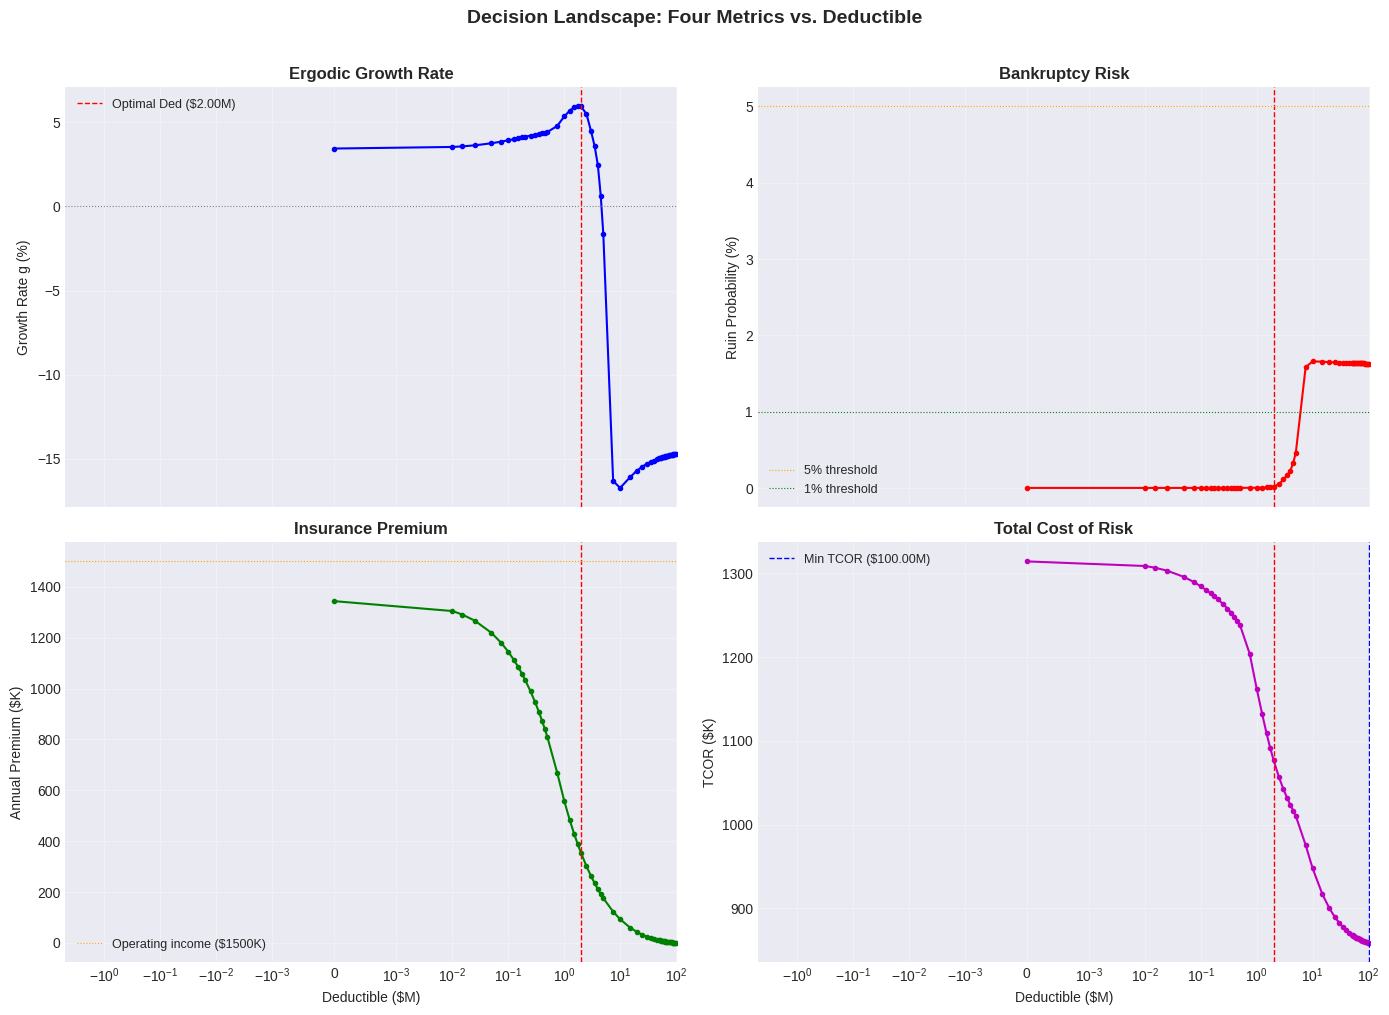


Metric                       Optimal Ded           Value
--------------------------------------------------------
Max ergodic growth        $    2,000,000  g = +0.0595
Min total cost of risk    $  100,000,000  TCOR = $   858,865


In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
ded_M = df_grid['ded'] / 1e6

# (1) Ergodic growth rate
ax = axes[0, 0]
ax.plot(ded_M, df_grid['growth_rate'] * 100, 'b-o', ms=3, lw=1.5)
ax.axvline(opt_ded / 1e6, color='red', ls='--', lw=1,
           label=f'Optimal Ded (${opt_ded/1e6:.2f}M)')
ax.axhline(0, color='grey', ls=':', lw=0.8)
ax.set_ylabel('Growth Rate g (%)')
ax.set_title('Ergodic Growth Rate', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (2) Ruin probability
ax = axes[0, 1]
ax.plot(ded_M, df_grid['ruin_prob'] * 100, 'r-o', ms=3, lw=1.5)
ax.axvline(opt_ded / 1e6, color='red', ls='--', lw=1)
ax.axhline(5, color='orange', ls=':', lw=0.8, label='5% threshold')
ax.axhline(1, color='green', ls=':', lw=0.8, label='1% threshold')
ax.set_ylabel('Ruin Probability (%)')
ax.set_title('Bankruptcy Risk', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (3) Annual premium
ax = axes[1, 0]
ax.plot(ded_M, df_grid['premium'] / 1_000, 'g-o', ms=3, lw=1.5)
ax.axvline(opt_ded / 1e6, color='red', ls='--', lw=1)
ax.axhline(E_oper / 1_000, color='orange', ls=':', lw=0.8,
           label=f'Operating income (${E_oper/1_000:.0f}K)')
ax.set_ylabel('Annual Premium ($K)')
ax.set_xlabel('Deductible ($M)')
ax.set_title('Insurance Premium', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (4) Total cost of risk
ax = axes[1, 1]
ax.plot(ded_M, df_grid['tcor'] / 1_000, 'm-o', ms=3, lw=1.5)
ax.axvline(opt_ded / 1e6, color='red', ls='--', lw=1)
tcor_min_idx = df_grid['tcor'].idxmin()
tcor_min_ded = df_grid.loc[tcor_min_idx, 'ded']
ax.axvline(tcor_min_ded / 1e6, color='blue', ls='--', lw=1,
           label=f'Min TCOR (${tcor_min_ded/1e6:.2f}M)')
ax.set_ylabel('TCOR ($K)')
ax.set_xlabel('Deductible ($M)')
ax.set_title('Total Cost of Risk', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

for ax in axes.flat:
    ax.set_xscale('symlog', linthresh=0.001)

plt.suptitle('Decision Landscape: Four Metrics vs. Deductible',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f"\n{'Metric':<24s}  {'Optimal Ded':>14s}  {'Value':>14s}")
print("-" * 56)
print(f"{'Max ergodic growth':<24s}  ${opt_ded:>13,.0f}  g = {opt_g:+.4f}")
print(f"{'Min total cost of risk':<24s}  ${tcor_min_ded:>13,.0f}  "
      f"TCOR = ${df_grid.loc[tcor_min_idx, 'tcor']:>10,.0f}")

### Wealth Distributions at Key Retention Levels

Comparing the *full distribution* of terminal wealth across strategies reveals what summary statistics hide:

- **Full insurance**: tight distribution, no ruin, but stunted upside (premium drag).
- **Optimal Ded**: slightly wider distribution, best median outcome, minimal left tail.
- **High retention / no insurance**: wide distribution with a heavy left tail (ruin mass).

The CDF (left) shows the cumulative probability structure; the box plots (right) give a quick visual comparison of medians and spreads.

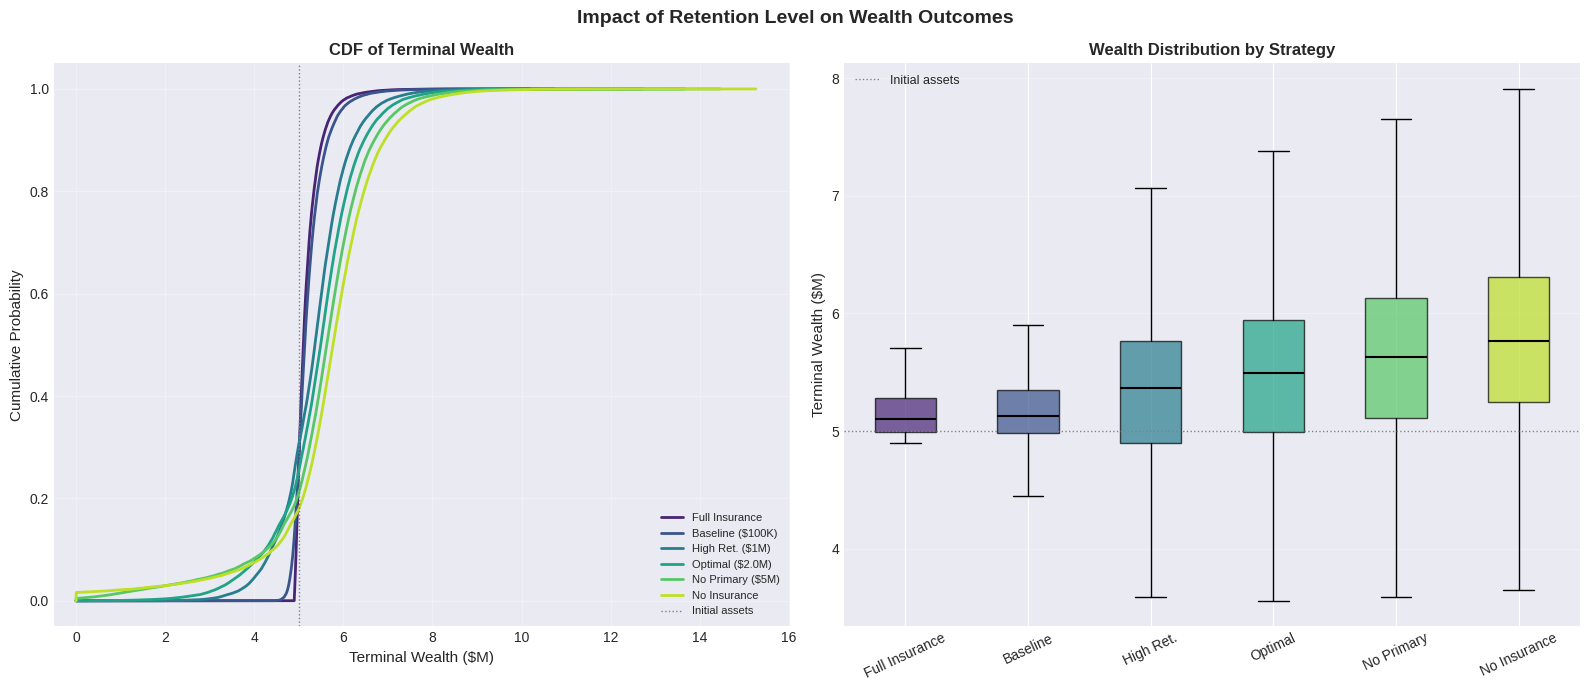


Strategy                  Median W         P10         P90   P(Ruin)
------------------------------------------------------------------
Full Insurance          $    5.10M  $    4.94M  $    5.53M    0.00%
Baseline                $    5.13M  $    4.88M  $    5.65M    0.00%
High Ret.               $    5.36M  $    4.38M  $    6.22M    0.01%
Optimal                 $    5.49M  $    4.25M  $    6.47M    0.02%
No Primary              $    5.63M  $    4.27M  $    6.70M    0.46%
No Insurance            $    5.77M  $    4.42M  $    6.93M    1.63%


In [34]:
# Key Ded levels to compare
key_deds = {
    0:             'Full Insurance',
    100_000:       'Baseline ($100K)',
    1_000_000:     'High Ret. ($1M)',
    5_000_000:     'No Primary ($5M)',
    100_000_000:   'No Insurance',
}
# Add optimal Ded (with star if it collides with a landmark)
opt_label = f'Optimal (${opt_ded/1e6:.1f}M)'
if opt_ded in key_deds:
    opt_label = f'{key_deds[opt_ded]} *'
key_deds[opt_ded] = opt_label
key_deds = dict(sorted(key_deds.items()))

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(key_deds)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: CDFs of terminal wealth
for (ded, label), color in zip(key_deds.items(), colors):
    nearest = min(wealth_pool.keys(), key=lambda s: abs(s - ded))
    W_T = np.sort(wealth_pool[nearest])
    cdf = np.linspace(0, 1, len(W_T))
    ax1.plot(W_T / 1e6, cdf, label=label, color=color, lw=2)

ax1.axvline(INITIAL_ASSETS / 1e6, color='grey', ls=':', lw=1, label='Initial assets')
ax1.set_xlabel('Terminal Wealth ($M)', fontsize=11)
ax1.set_ylabel('Cumulative Probability', fontsize=11)
ax1.set_title('CDF of Terminal Wealth', fontweight='bold')
ax1.legend(fontsize=8, loc='lower right')
ax1.set_xlim(left=-0.5)
ax1.grid(True, alpha=0.3)

# Right: Box plots (no outliers for readability)
bp_data = []
bp_labels = []
for ded, label in key_deds.items():
    nearest = min(wealth_pool.keys(), key=lambda s: abs(s - ded))
    bp_data.append(wealth_pool[nearest] / 1e6)
    bp_labels.append(label.split('(')[0].strip())

bp = ax2.boxplot(bp_data, labels=bp_labels, patch_artist=True, showfliers=False,
                 medianprops=dict(color='black', lw=1.5))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.axhline(INITIAL_ASSETS / 1e6, color='grey', ls=':', lw=1, label='Initial assets')
ax2.set_ylabel('Terminal Wealth ($M)', fontsize=11)
ax2.set_title('Wealth Distribution by Strategy', fontweight='bold')
ax2.tick_params(axis='x', rotation=25)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('Impact of Retention Level on Wealth Outcomes',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'Strategy':<22s}  {'Median W':>10s}  {'P10':>10s}  {'P90':>10s}  {'P(Ruin)':>8s}")
print("-" * 66)
for ded, label in key_deds.items():
    nearest = min(wealth_pool.keys(), key=lambda s: abs(s - ded))
    W_T = wealth_pool[nearest]
    short = label.split('(')[0].strip()
    print(f"{short:<22s}  ${np.median(W_T)/1e6:>8.2f}M  "
          f"${np.percentile(W_T,10)/1e6:>8.2f}M  "
          f"${np.percentile(W_T,90)/1e6:>8.2f}M  "
          f"{np.mean(W_T<=0):>7.2%}")


## Part III: Optimal Tradeoff Frontier

As the decision-maker's preference shifts between **growth maximization** and **ruin avoidance**, the optimal deductible changes.  We sweep the growth weight $w$ from 0 (pure safety) to 1 (pure growth) and record the weighted-sum optimum at each preference level.


In [35]:
# ---- Part III: Optimal Tradeoff Frontier ----
# The Pareto frontier (non-dominated set) is determined by the
# simulation results from Part II and does NOT change with preference
# weights.  What shifts is which frontier point a weighted-sum
# scalarization selects as "optimal."
#
# We sweep growth_weight w from 0 (pure ruin-minimization) to 1
# (pure growth-maximization) and record the selected optimum.

growth_weights = np.linspace(0.0, 1.0, 20)  # 3 points to start
optimal_dict = {}

# Re-use simulation results from Part II
g_vals = df_grid['growth_rate'].values
r_vals = df_grid['ruin_prob'].values
g_min, g_max = g_vals.min(), g_vals.max()
r_min, r_max = r_vals.min(), r_vals.max()
g_range = max(g_max - g_min, 1e-12)
r_range = max(r_max - r_min, 1e-12)

min_frontier = None
max_frontier = None

for w in growth_weights:
    # Weighted score: w * normalized_growth + (1-w) * normalized_safety
    g_norm = (g_vals - g_min) / g_range
    r_norm = (r_max - r_vals) / r_range  # flipped: low ruin = high score
    scores = w * g_norm + (1 - w) * r_norm
    opt_idx = np.argmax(scores)

    # Build Pareto frontier with these weights
    obj_w = [
        Objective("growth_rate", ObjectiveType.MAXIMIZE,
                  weight=max(w, 0.001)),
        Objective("ruin_prob", ObjectiveType.MINIMIZE,
                  weight=max(1 - w, 0.001)),
    ]
    frontier = ParetoFrontier(
        objectives=obj_w,
        objective_function=sim_objectives,
        bounds=[(0, 100_000_000)],
        seed=SEED,
    )
    all_pts = [
        ParetoPoint(
            objectives={'growth_rate': row['growth_rate'],
                        'ruin_prob': row['ruin_prob']},
            decision_variables=np.array([row['ded']]),
        )
        for _, row in df_grid.iterrows()
    ]
    frontier.frontier_points = frontier._filter_dominated_points(all_pts)
    frontier._calculate_crowding_distances()
    frontier._calculate_trade_offs()

    optimal_dict[w] = {
        'frontier': frontier,
        'optimal_ded': df_grid.iloc[opt_idx]['ded'],
        'optimal_growth': df_grid.iloc[opt_idx]['growth_rate'],
        'optimal_ruin': df_grid.iloc[opt_idx]['ruin_prob'],
        'optimal_premium': df_grid.iloc[opt_idx]['premium'],
        'frontier_deds': sorted(
            [p.decision_variables[0] for p in frontier.frontier_points]),
    }

    min_frontier = min(min_frontier, min(optimal_dict[w]['frontier_deds'])) if min_frontier else min(optimal_dict[w]['frontier_deds'])
    max_frontier = max(max_frontier, max(optimal_dict[w]['frontier_deds'])) if max_frontier else max(optimal_dict[w]['frontier_deds'])

    print(f"  w={w:.2f}:  Optimal Ded = ${optimal_dict[w]['optimal_ded']:>12,.0f}  "
          f"g = {optimal_dict[w]['optimal_growth']:+.4f}  "
          f"P(ruin) = {optimal_dict[w]['optimal_ruin']:.2%}  "
          f"({len(frontier.frontier_points)} non-dominated)")

  w=0.00:  Optimal Ded = $           0  g = +0.0344  P(ruin) = 0.00%  (6 non-dominated)
  w=0.05:  Optimal Ded = $   1,000,000  g = +0.0535  P(ruin) = 0.01%  (6 non-dominated)
  w=0.11:  Optimal Ded = $   1,250,000  g = +0.0569  P(ruin) = 0.01%  (6 non-dominated)
  w=0.16:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.21:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.26:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.32:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.37:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.42:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.47:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.53:  Optimal Ded = $   1,500,000  g = +0.0590  P(ruin) = 0.01%  (6 non-dominated)
  w=0.58:  Optimal Ded = $   1,5

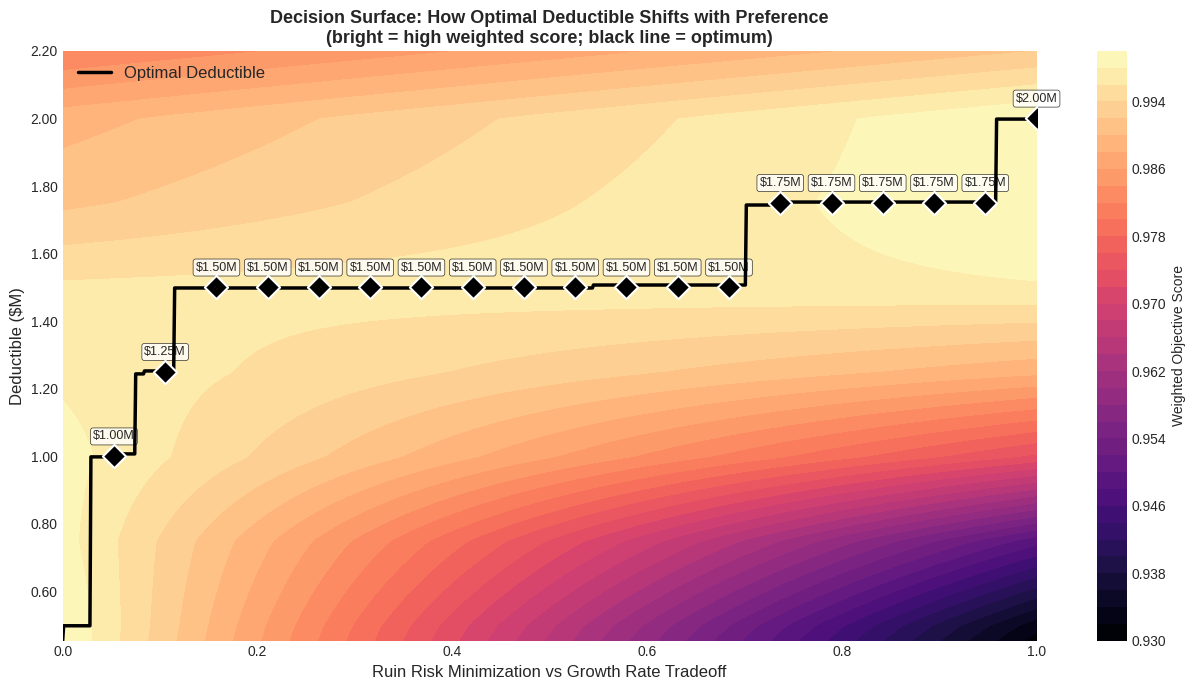

In [36]:
import matplotlib.ticker as ticker

def format_retention(val, pos):
    if val < 1e3:
        return f"{val:,.2f}"
    elif val < 1e6:
        return f"{val/1e3:.0f}K"
    elif val < 1e9:
        return f"{val/1e6:.2f}M"
    else:
        return f"{val/1e9:.2f}B"

# --- Plot 1: Decision Surface — Optimal Ded vs Preference Weight ---
# Interpolate objectives onto a fine (weight, ded) grid and show the
# weighted score as a filled contour.  The black line traces the optimum.

fine_weights = np.linspace(0.0, 1.0, 1001)

# Focus on the range that covers all non-dominated deds
ded_fine = np.concatenate([
    np.linspace(min_frontier / 1.1, max_frontier * 1.1, 200),
])

# Interpolated objectives on the fine ded grid
g_interp = np.interp(ded_fine, _s, _g)
r_interp = np.interp(ded_fine, _s, _r)
g_norm_fine = (g_interp - g_min) / g_range
r_norm_fine = (r_max - r_interp) / r_range

# Build score mesh: shape (len(ded_fine), len(fine_weights))
W_mesh, D_mesh = np.meshgrid(fine_weights, ded_fine)
G_tile = np.tile(g_norm_fine[:, None], (1, len(fine_weights)))
R_tile = np.tile(r_norm_fine[:, None], (1, len(fine_weights)))
score_mesh = W_mesh * G_tile + (1 - W_mesh) * R_tile

# Optimal ded at each fine weight
optimal_deds_fine = ded_fine[np.argmax(score_mesh, axis=0)]

fig, ax = plt.subplots(figsize=(13, 7))
cf = ax.contourf(W_mesh, D_mesh / 1e6, score_mesh, levels=40, cmap='magma')
plt.colorbar(cf, ax=ax, label='Weighted Objective Score')

ax.plot(fine_weights, optimal_deds_fine / 1e6, 'k-', lw=2.5,
        label='Optimal Deductible', zorder=5)

for w in growth_weights:
    info = optimal_dict[w]
    ax.scatter(w, info['optimal_ded'] / 1e6, s=140, marker='D',
               edgecolors='white', c='black', linewidth=1.5, zorder=6)
    ax.annotate(f"${info['optimal_ded']/1e6:.2f}M",
                (w, info['optimal_ded'] / 1e6), fontsize=9,
                ha='center', va='bottom', xytext=(0, 10),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', fc='white',
                          alpha=0.8, lw=0.5))

ax.set_xlabel('Ruin Risk Minimization vs Growth Rate Tradeoff', fontsize=12)
ax.set_ylabel('Deductible ($M)', fontsize=12)
ax.set_title('Decision Surface: How Optimal Deductible Shifts with Preference\n'
             '(bright = high weighted score; black line = optimum)',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
# ax.set_ylim(bottom=1)
ax.grid(True, alpha=0.2)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_retention))
plt.ylim(min_frontier / 1e6 / 1.1, max_frontier / 1e6 * 1.1)
# ax.ticklabel_format(style='plain', axis='both')
plt.tight_layout()
plt.show()

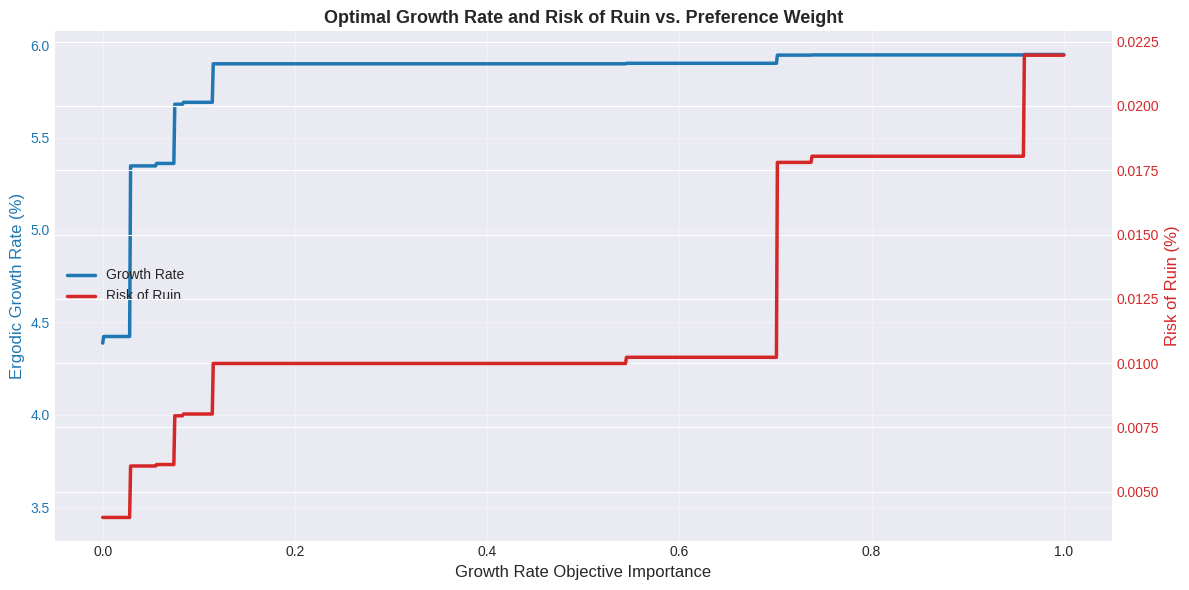

In [37]:
# --- Plot 2: Growth Rate and Risk of Ruin at the Optimal Ded ---
opt_growth_fine = np.interp(optimal_deds_fine, _s, _g)
opt_ruin_fine = np.interp(optimal_deds_fine, _s, _r)

fig, ax1 = plt.subplots(figsize=(12, 6))

color_g = 'tab:blue'
color_r = 'tab:red'

ax1.set_xlabel('Growth Rate Objective Importance', fontsize=12)
ax1.set_ylabel('Ergodic Growth Rate (%)', color=color_g, fontsize=12)
ln1 = ax1.plot(fine_weights, opt_growth_fine * 100, '-',
               color=color_g, lw=2.5, label='Growth Rate')
ax1.tick_params(axis='y', labelcolor=color_g)

ax2 = ax1.twinx()
ax2.set_ylabel('Risk of Ruin (%)', color=color_r, fontsize=12)
ln2 = ax2.plot(fine_weights, opt_ruin_fine * 100, '-',
               color=color_r, lw=2.5, label='Risk of Ruin')
ax2.tick_params(axis='y', labelcolor=color_r)

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', fontsize=10)

for w in growth_weights:
    info = optimal_dict[w]
    ax1.scatter(w, info['optimal_growth'] * 100, s=100, marker='',
                edgecolors='k', c=color_g, linewidth=1, zorder=5)
    ax2.scatter(w, info['optimal_ruin'] * 100, s=100, marker='',
                edgecolors='k', c=color_r, linewidth=1, zorder=5)

ax1.set_title('Optimal Growth Rate and Risk of Ruin vs. Preference Weight',
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

#### Trade-off between deductible level and premium cost at the optimum.

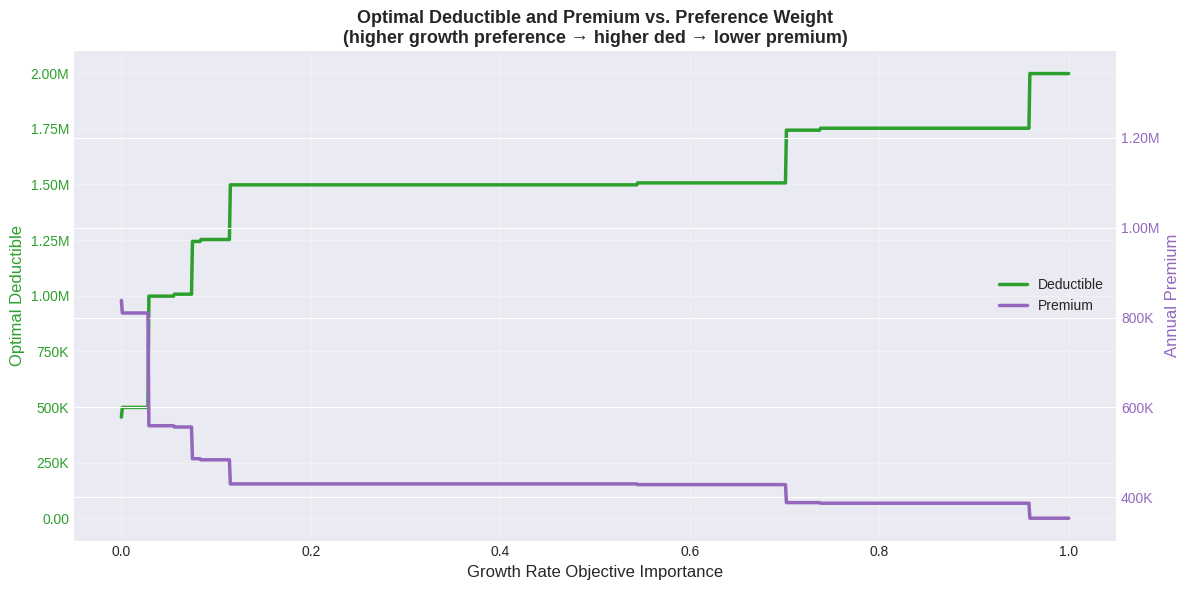

In [38]:
# --- Plot 4: Optimal Ded and Premium vs. Preference Weight ---
opt_prem_fine = np.interp(optimal_deds_fine, _s, _p)

fig, ax1 = plt.subplots(figsize=(12, 6))
color_d = 'tab:green'
color_p = 'tab:purple'

ax1.set_xlabel('Growth Rate Objective Importance', fontsize=12)
ax1.set_ylabel('Optimal Deductible', color=color_d, fontsize=12)
ln1 = ax1.plot(fine_weights, optimal_deds_fine, '-',
               color=color_d, lw=2.5, label='Deductible')
ax1.tick_params(axis='y', labelcolor=color_d)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_retention))

ax2 = ax1.twinx()
ax2.set_ylabel('Annual Premium', color=color_p, fontsize=12)
ln2 = ax2.plot(fine_weights, opt_prem_fine, '-',
               color=color_p, lw=2.5, label='Premium')
ax2.tick_params(axis='y', labelcolor=color_p)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_retention))

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize=10)

for w in growth_weights:
    info = optimal_dict[w]
    ax1.scatter(w, info['optimal_ded'], s=100, marker='',
                edgecolors='k', c=color_d, linewidth=1, zorder=5)
    ax2.scatter(w, info['optimal_premium'], s=100, marker='',
                edgecolors='k', c=color_p, linewidth=1, zorder=5)

ax1.set_title('Optimal Deductible and Premium vs. Preference Weight\n'
              '(higher growth preference → higher ded → lower premium)',
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## Part IV: Probabilistic Sensitivity Analysis: Large Loss Variability's Impact on the Decision Surface

Create a prior distribution on the Large Loss CV

In [173]:
from tqdm.auto import tqdm
from scipy.stats import gamma as gamma_dist

SEED = 42
np.random.seed(SEED)

# --- Gamma prior on Large Loss CV ---
CV_SAMPLES = 100
GAMMA_SHAPE, GAMMA_SCALE = 5.0, 1.0
gamma_lg_cvs = np.sort(np.random.gamma(GAMMA_SHAPE, GAMMA_SCALE, CV_SAMPLES))

warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)


def make_sensitivity_pricers(large_sev_cv, cur_revenue=REFERENCE_REVENUE):
    """LayerPricers with a specific large-loss CV."""
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=LG_SEV_MEAN, cv=large_sev_cv),
                    frequency=LG_BASE_FREQ * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )


all_records = []
cv_sim_data = {}
optimal_dict = {}
wealth_pool = {}
min_frontier = None
max_frontier = None

SENS_N_PATHS = 10_000
SENS_GROWTH_WEIGHTS = np.linspace(0.0, 1.0, 21)

for lg_cv in tqdm(gamma_lg_cvs, desc="Sensitivity sweep over Large Loss CV"):
    cv_records = []
    sens_pricers = make_sensitivity_pricers(lg_cv)

    # Generate loss pool WITH this CV
    # (temporarily patch global LOSS_PARAMS so generate_loss_pool uses it)
    _saved_cv = LOSS_PARAMS['large_params']['severity_cv']
    LOSS_PARAMS['large_params']['severity_cv'] = lg_cv
    CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(
        n_paths=SENS_N_PATHS, n_years=1, seed=SEED)
    LOSS_PARAMS['large_params']['severity_cv'] = _saved_cv

    # --- Simulation engine with sensitivity-correct pricing ---
    def simulate_sens_with_crn(ded, revenue_shocks, loss_pool, n_years=1,
                               initial_assets=INITIAL_ASSETS, pricers=sens_pricers):
        n_paths = len(loss_pool)
        paths = np.zeros((n_paths, n_years + 1))
        paths[:, 0] = initial_assets

        if ded >= 100_000_000:
            annual_premium = 0.0
            use_insurance = False
        else:
            program_template = make_program(ded, pricers=pricers)
            annual_premium = program_template.calculate_premium()
            use_insurance = True

        for i in range(n_paths):
            assets = initial_assets
            for t in range(n_years):
                revenue = assets * ATR * np.exp(
                    REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2)
                operating_income = revenue * OPERATING_MARGIN
                loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

                total_retained = 0.0
                if use_insurance:
                    new_pricers = make_sensitivity_pricers(lg_cv, cur_revenue=revenue)
                    program_update = make_program(ded, pricers=new_pricers)
                    annual_premium = program_update.calculate_premium()
                    program = InsuranceProgram.create_fresh(program_update)
                    for event in loss_pool[i][t]:
                        scaled_amount = event.amount * loss_scale
                        result = program.process_claim(scaled_amount)
                        total_retained += result.deductible_paid + result.uncovered_loss
                else:
                    for event in loss_pool[i][t]:
                        total_retained += event.amount * loss_scale

                assets = assets + operating_income - total_retained - annual_premium
                assets = max(assets, 0.0)
                paths[i, t + 1] = assets

        return paths

    def _run_sens_single_ded(ded_value):
        """Simulates one Ded strategy under current sensitivity CV."""
        paths = simulate_sens_with_crn(ded_value, CRN_SHOCKS, CRN_LOSSES, n_years=1)
        W_T = paths[:, -1]
        g = np.mean(np.log(np.maximum(W_T, 1.0) / INITIAL_ASSETS))
        ruin = np.mean(W_T <= 0)
        prem = make_program(ded_value, pricers=sens_pricers).calculate_premium() \
               if ded_value < 100_000_000 else 0.0
        return ded_value, dict(
            ded=ded_value, lg_cv=lg_cv,
            growth_rate=g, ruin_prob=ruin, premium=prem,
            mean_wealth=np.mean(W_T), median_wealth=np.median(W_T),
            std_wealth=np.std(W_T),
            p10=np.percentile(W_T, 10), p90=np.percentile(W_T, 90),
        ), W_T

    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(_run_sens_single_ded, ded_grid))

    for k, (ded, record, W_T) in enumerate(results):
        all_records.append(record)
        cv_records.append(record)
        wealth_pool[(lg_cv, ded)] = W_T

    df_cv = pd.DataFrame(cv_records)
    _s_cv = df_cv['ded'].values
    _g_cv = df_cv['growth_rate'].values
    _r_cv = df_cv['ruin_prob'].values
    _p_cv = df_cv['premium'].values
    g_min_cv, g_max_cv = _g_cv.min(), _g_cv.max()
    r_min_cv, r_max_cv = _r_cv.min(), _r_cv.max()
    g_range_cv = max(g_max_cv - g_min_cv, 1e-12)
    r_range_cv = max(r_max_cv - r_min_cv, 1e-12)

    cv_sim_data[lg_cv] = {
        's': _s_cv.copy(), 'g': _g_cv.copy(),
        'r': _r_cv.copy(), 'p': _p_cv.copy(),
        'g_min': g_min_cv, 'g_max': g_max_cv,
        'r_min': r_min_cv, 'r_max': r_max_cv,
    }

    for w in SENS_GROWTH_WEIGHTS:
        g_norm = (_g_cv - g_min_cv) / g_range_cv
        r_norm = (r_max_cv - _r_cv) / r_range_cv
        scores = w * g_norm + (1 - w) * r_norm
        opt_idx = np.argmax(scores)
        optimal_dict[(lg_cv, w)] = {
            'optimal_ded': df_cv.iloc[opt_idx]['ded'],
            'optimal_growth': df_cv.iloc[opt_idx]['growth_rate'],
            'optimal_ruin': df_cv.iloc[opt_idx]['ruin_prob'],
            'optimal_premium': df_cv.iloc[opt_idx]['premium'],
        }
        fd = df_cv.iloc[opt_idx]['ded']
        min_frontier = min(min_frontier, fd) if min_frontier is not None else fd
        max_frontier = max(max_frontier, fd) if max_frontier is not None else fd

df_all = pd.DataFrame(all_records)
print(f"\nDone: {len(gamma_lg_cvs)} CV samples x {len(ded_grid)} deds x {SENS_N_PATHS:,} paths")
print(f"CV range: [{gamma_lg_cvs.min():.2f}, {gamma_lg_cvs.max():.2f}]")
print(f"Frontier ded range: ${min_frontier:,.0f} - ${max_frontier:,.0f}")

Sensitivity sweep over Large Loss CV:   0%|          | 0/100 [00:00<?, ?it/s]


Done: 100 CV samples x 58 deds x 10,000 paths
CV range: [1.63, 12.27]
Frontier ded range: $0 - $2,500,000


### Optimal Deductible Surface

Saved bayesian_decision_cloud.gif


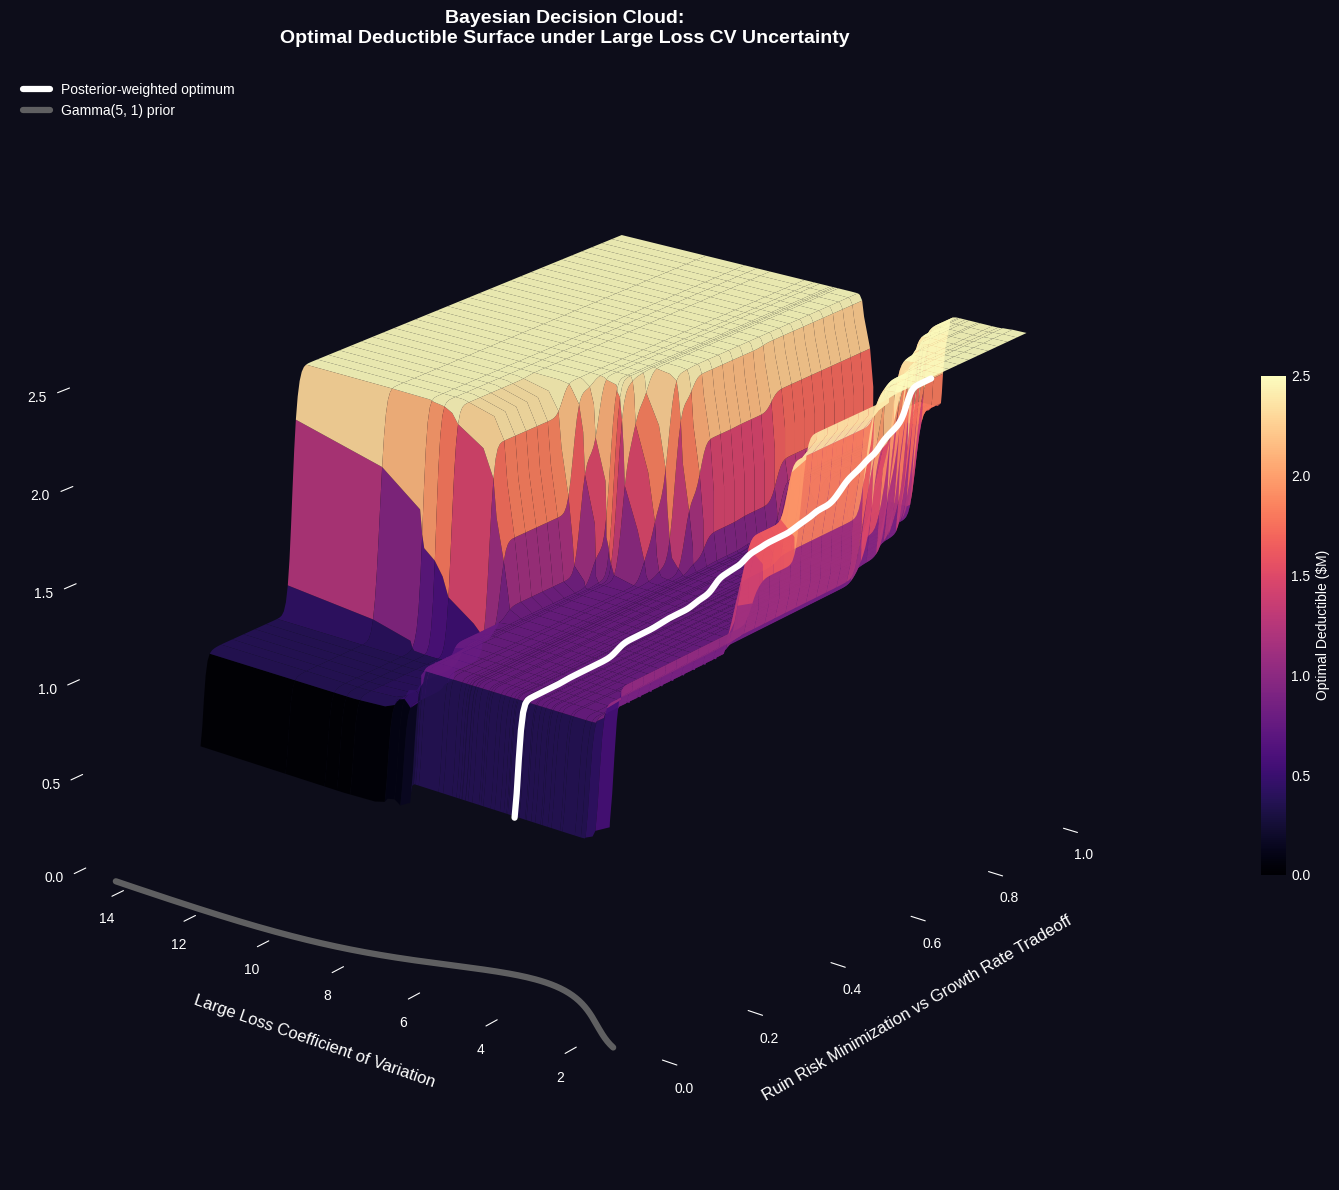

In [179]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mcm
from matplotlib.colors import LightSource
from scipy.ndimage import gaussian_filter
import imageio.v2 as imageio
import io

# --- Compute optimal deductible surface on a fine grid ---
fine_w = np.linspace(0, 1, 201)
opt_surface = np.zeros((len(gamma_lg_cvs), len(fine_w)))

for cv_idx, lg_cv in enumerate(gamma_lg_cvs):
    data = cv_sim_data[lg_cv]
    _s, _g, _r = data['s'], data['g'], data['r']
    g_rng = max(data['g_max'] - data['g_min'], 1e-12)
    r_rng = max(data['r_max'] - data['r_min'], 1e-12)

    ded_fine = np.linspace(min_frontier / 1.1, max_frontier * 1.1, 300)
    g_i = np.interp(ded_fine, _s, _g)
    r_i = np.interp(ded_fine, _s, _r)
    g_n = (g_i - data['g_min']) / g_rng
    r_n = (data['r_max'] - r_i) / r_rng

    for w_idx, w in enumerate(fine_w):
        score = w * g_n + (1 - w) * r_n
        opt_surface[cv_idx, w_idx] = ded_fine[np.argmax(score)]

opt_surface_smooth = gaussian_filter(opt_surface, sigma=[1.5, 2.0])

# --- Gamma PDF for transparency weighting ---
pdf_vals = gamma_dist.pdf(gamma_lg_cvs, GAMMA_SHAPE, scale=GAMMA_SCALE)
pdf_norm = pdf_vals / pdf_vals.max()

# --- 3D Cloud Plot ---
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

W_mesh, CV_mesh = np.meshgrid(fine_w, gamma_lg_cvs)

# RGBA facecolors: color = deductible value, alpha = gamma density
norm_ded = Normalize(vmin=opt_surface.min() / 1e6, vmax=opt_surface.max() / 1e6)
fcolors = mcm.viridis(norm_ded(opt_surface / 1e6))
for cv_idx in range(len(gamma_lg_cvs)):
    fcolors[cv_idx, :, 3] = 0.04 + 0.50 * pdf_norm[cv_idx]

ax.plot_surface(W_mesh, CV_mesh, opt_surface_smooth / 1e6,
                cmap='magma',          # high contrast, perceptually uniform
                shade=True,
                lightsource=LightSource(azdeg=315, altdeg=45),
                alpha=0.92,
                edgecolor='none',
                antialiased=True)

offset_z = opt_surface_smooth.min() / 1e6

weights = pdf_norm / pdf_norm.sum()
expected_opt = (opt_surface_smooth * weights[:, None]).sum(axis=0)

# Thicken the posterior line — it gets thinner-looking at low elev
ax.plot(fine_w, np.full_like(fine_w, gamma_lg_cvs[pdf_norm.argmax()]),
        expected_opt / 1e6, color='white', linewidth=4.5, zorder=20,
        label='Posterior-weighted optimum')

# Gamma PDF projection — pushed to w = -0.05 wall
cv_dense = np.linspace(max(0.5, gamma_lg_cvs.min() * 0.7),
                       gamma_lg_cvs.max() * 1.15, 200)
pdf_dense = gamma_dist.pdf(cv_dense, GAMMA_SHAPE, scale=GAMMA_SCALE)
pdf_scaled = pdf_dense / pdf_dense.max() * 0.12
z_base = opt_surface.min() / 1e6

ax.plot(pdf_scaled - 0.05, cv_dense, np.full_like(cv_dense, z_base),
        color='dimgray', alpha=0.9, linewidth=4.5, linestyle='-',
        label=f'Gamma({GAMMA_SHAPE:.0f}, {GAMMA_SCALE:.0f}) prior')

ax.set_xlim(-0.05, 1.0)
ax.set_xlabel('\nRuin Risk Minimization vs Growth Rate Tradeoff', fontsize=12, labelpad=12)
ax.set_ylabel('\nLarge Loss Coefficient of Variation', fontsize=12, labelpad=12)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Optimal Deductible ($M)', fontsize=12, labelpad=60, color='white', rotation=90)
ax.set_title('Bayesian Decision Cloud:\nOptimal Deductible Surface under Large Loss CV Uncertainty',
             fontsize=14, fontweight='bold', pad=20)
# Viewing angle: adjust elev/azim to re-orient the static render
ax.view_init(elev=22, azim=218)
ax.set_facecolor('#0d0d1a')
ax.grid(False)
ax.legend(loc='upper left', fontsize=10)

sm = plt.cm.ScalarMappable(cmap='magma', norm=norm_ded)
sm.set_array([])

# White text throughout
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.zaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')
ax.title.set_color('white')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')
ax.legend(loc='upper left', fontsize=10, labelcolor='white', facecolor='#0d0d1a', edgecolor='white')

# Colorbar text
cbar = fig.colorbar(sm, ax=ax, shrink=0.45, pad=0.08, label='Optimal Deductible ($M)')
cbar.set_label('Optimal Deductible ($M)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')

# Figure background to match
fig.patch.set_facecolor('#0d0d1a')

plt.tight_layout()
# Define your 7 angles as (elev, azim) pairs
angles = [
    (22, 218),
    (22, 214),
    (22, 210),
    (22, 206),
    (22, 202),
    (22, 198),
    (22, 194),
    (22, 190),
    (22, 186),
    (22, 182),
    (22, 186),
    (22, 190),
    (22, 194),
    (22, 198),
    (22, 202),
    (22, 206),
    (22, 210),
    (22, 214),
    (22, 218),
    (22, 218),
    (22, 218),
    (22, 218),
    (22, 218),
]

frames = []

for elev, azim in angles:
    ax.view_init(elev=elev, azim=azim)

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=150, facecolor=fig.get_facecolor())
    buf.seek(0)
    frames.append(imageio.imread(buf))
    buf.close()

imageio.mimsave(
    'bayesian_decision_cloud.gif',
    frames,
    duration=100,   # ms per frame
    loop=0          # 0 = infinite loop
)

print("Saved bayesian_decision_cloud.gif")
plt.show()

### Decision Uncertainty Propagation

The **uncertainty fan chart** below shows how prior uncertainty about the large-loss CV
propagates to uncertainty about the optimal deductible.  The credible bands are computed
as gamma-weighted percentiles across the CV samples.

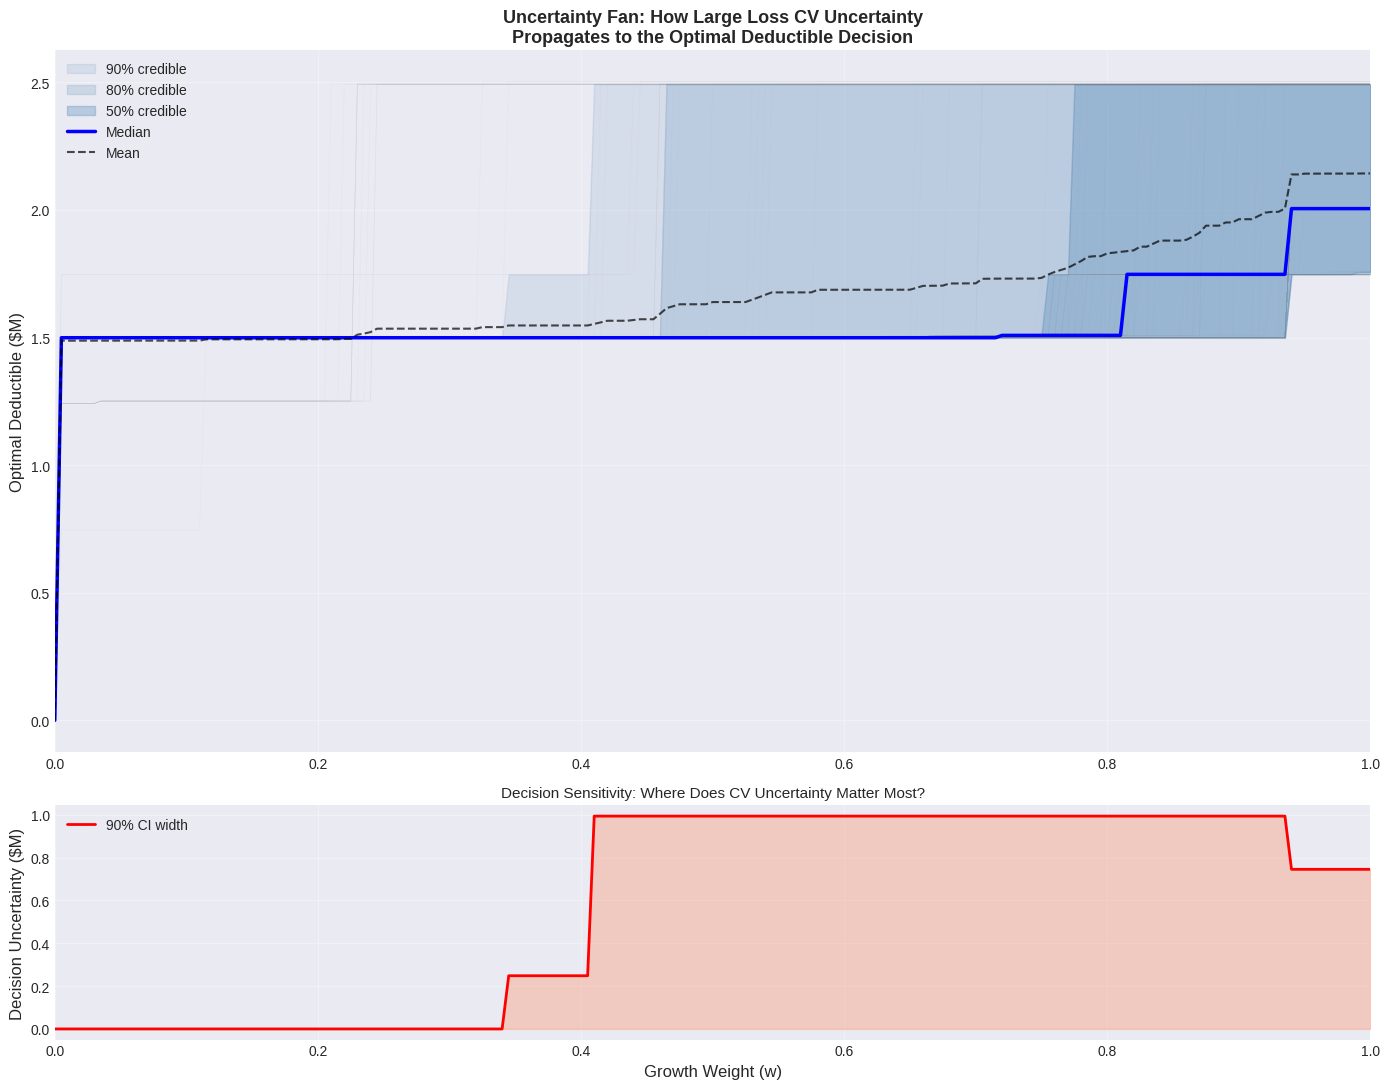

In [175]:
# --- Credible Interval Fan Chart ---
weights_gamma = pdf_vals / pdf_vals.sum()  # normalised to probability

pcts = [5, 10, 25, 50, 75, 90, 95]
ded_pcts = {p: np.zeros(len(fine_w)) for p in pcts}
ded_mean = np.zeros(len(fine_w))

for w_idx in range(len(fine_w)):
    deds_w = opt_surface[:, w_idx] / 1e6
    si = np.argsort(deds_w)
    sd = deds_w[si]
    sw = weights_gamma[si]
    cw = np.cumsum(sw)
    for p in pcts:
        idx = min(np.searchsorted(cw, p / 100.0), len(sd) - 1)
        ded_pcts[p][w_idx] = sd[idx]
    ded_mean[w_idx] = np.dot(deds_w, weights_gamma)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 11),
                                gridspec_kw={'height_ratios': [3, 1]})

# --- Upper panel: credible bands ---
ax1.fill_between(fine_w, ded_pcts[5],  ded_pcts[95],
                 alpha=0.12, color='steelblue', label='90% credible')
ax1.fill_between(fine_w, ded_pcts[10], ded_pcts[90],
                 alpha=0.18, color='steelblue', label='80% credible')
ax1.fill_between(fine_w, ded_pcts[25], ded_pcts[75],
                 alpha=0.30, color='steelblue', label='50% credible')
ax1.plot(fine_w, ded_pcts[50], 'b-', lw=2.5, label='Median', zorder=5)
ax1.plot(fine_w, ded_mean, 'k--', lw=1.5, alpha=0.7, label='Mean', zorder=5)

for cv_idx in range(len(gamma_lg_cvs)):
    ax1.plot(fine_w, opt_surface[cv_idx] / 1e6,
             color='gray', alpha=0.06, linewidth=0.4)

ax1.set_ylabel('Optimal Deductible ($M)', fontsize=12)
ax1.set_title('Uncertainty Fan: How Large Loss CV Uncertainty\n'
              'Propagates to the Optimal Deductible Decision',
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)

# --- Lower panel: decision uncertainty width ---
fan_width = ded_pcts[95] - ded_pcts[5]
ax2.fill_between(fine_w, 0, fan_width, alpha=0.3, color='coral')
ax2.plot(fine_w, fan_width, 'r-', lw=2, label='90% CI width')
ax2.set_xlabel('Growth Weight (w)', fontsize=12)
ax2.set_ylabel('Decision Uncertainty ($M)', fontsize=12)
ax2.set_title('Decision Sensitivity: Where Does CV Uncertainty Matter Most?',
              fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

### Sensitivity Dashboard

Three views of how large-loss tail thickness affects optimal insurance decisions:
1. **Decision map** &mdash; how the optimal deductible shifts with both growth preference and CV
2. **Achievable growth** &mdash; maximum ergodic growth rate as a function of tail thickness
3. **Residual ruin risk** &mdash; ruin probability at the balanced-preference optimum

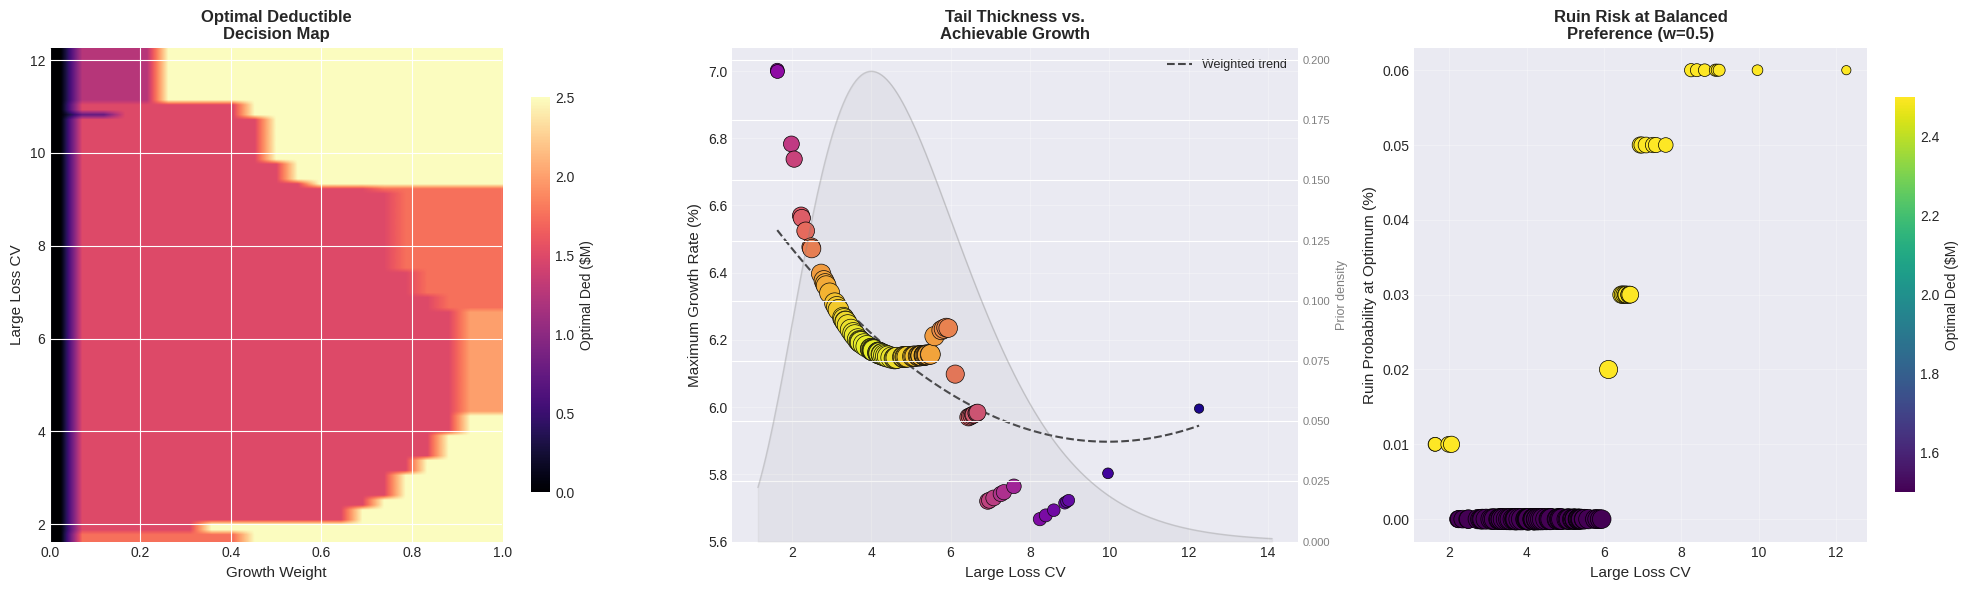

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Panel 1: Heatmap of optimal deductible ---
ax = axes[0]
w_grid = SENS_GROWTH_WEIGHTS
heatmap = np.zeros((len(gamma_lg_cvs), len(w_grid)))
for cv_idx, lg_cv in enumerate(gamma_lg_cvs):
    for w_idx, w in enumerate(w_grid):
        heatmap[cv_idx, w_idx] = optimal_dict[(lg_cv, w)]['optimal_ded'] / 1e6

im = ax.imshow(heatmap, aspect='auto', origin='lower', cmap='magma',
               extent=[w_grid[0], w_grid[-1], gamma_lg_cvs[0], gamma_lg_cvs[-1]],
               interpolation='bilinear')
ax.set_xlabel('Growth Weight', fontsize=11)
ax.set_ylabel('Large Loss CV', fontsize=11)
ax.set_title('Optimal Deductible\nDecision Map', fontsize=12, fontweight='bold')
fig.colorbar(im, ax=ax, label='Optimal Ded ($M)', shrink=0.8)

# --- Panel 2: Max growth rate vs CV ---
ax = axes[1]
max_growth = np.array([cv_sim_data[cv]['g'].max() for cv in gamma_lg_cvs])
sizes = 40 + 200 * pdf_norm
sc = ax.scatter(gamma_lg_cvs, max_growth * 100,
                c=mcm.plasma(pdf_norm), s=sizes,
                edgecolors='black', linewidth=0.5, zorder=5)

z = np.polyfit(gamma_lg_cvs, max_growth * 100, 2, w=weights_gamma)
cv_smooth = np.linspace(gamma_lg_cvs.min(), gamma_lg_cvs.max(), 100)
ax.plot(cv_smooth, np.polyval(z, cv_smooth), 'k--', lw=1.5, alpha=0.7,
        label='Weighted trend')

# Gamma density overlay
ax_tw = ax.twinx()
cv_d = np.linspace(max(0.5, gamma_lg_cvs.min() * 0.7),
                   gamma_lg_cvs.max() * 1.15, 200)
pdf_d = gamma_dist.pdf(cv_d, GAMMA_SHAPE, scale=GAMMA_SCALE)
ax_tw.fill_between(cv_d, 0, pdf_d, alpha=0.08, color='gray')
ax_tw.plot(cv_d, pdf_d, 'gray', alpha=0.3, lw=1)
ax_tw.set_ylabel('Prior density', fontsize=9, color='gray')
ax_tw.tick_params(axis='y', labelcolor='gray', labelsize=8)
ax_tw.set_ylim(bottom=0)

ax.set_xlabel('Large Loss CV', fontsize=11)
ax.set_ylabel('Maximum Growth Rate (%)', fontsize=11)
ax.set_title('Tail Thickness vs.\nAchievable Growth', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 3: Ruin at balanced preference ---
ax = axes[2]
w_mid = 0.5
w_closest = SENS_GROWTH_WEIGHTS[np.argmin(np.abs(SENS_GROWTH_WEIGHTS - w_mid))]
opt_ruins = np.array([optimal_dict[(cv, w_closest)]['optimal_ruin']
                       for cv in gamma_lg_cvs])
opt_deds_mid = np.array([optimal_dict[(cv, w_closest)]['optimal_ded']
                          for cv in gamma_lg_cvs])

sc2 = ax.scatter(gamma_lg_cvs, opt_ruins * 100,
                 c=opt_deds_mid / 1e6, cmap='viridis',
                 s=sizes, edgecolors='black', linewidth=0.5, zorder=5)
fig.colorbar(sc2, ax=ax, label='Optimal Ded ($M)', shrink=0.8)

ax.set_xlabel('Large Loss CV', fontsize=11)
ax.set_ylabel('Ruin Probability at Optimum (%)', fontsize=11)
ax.set_title(f'Ruin Risk at Balanced\nPreference (w={w_closest:.1f})',
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Decision Surface Cross-Sections

The contour plots below show the full **weighted-objective score landscape** at three
quantiles of the gamma prior (10th, 50th, 90th percentile of the large-loss CV).
The white trace marks the optimal deductible at each growth preference.  Comparing
across panels reveals how tail thickness reshapes the decision surface.

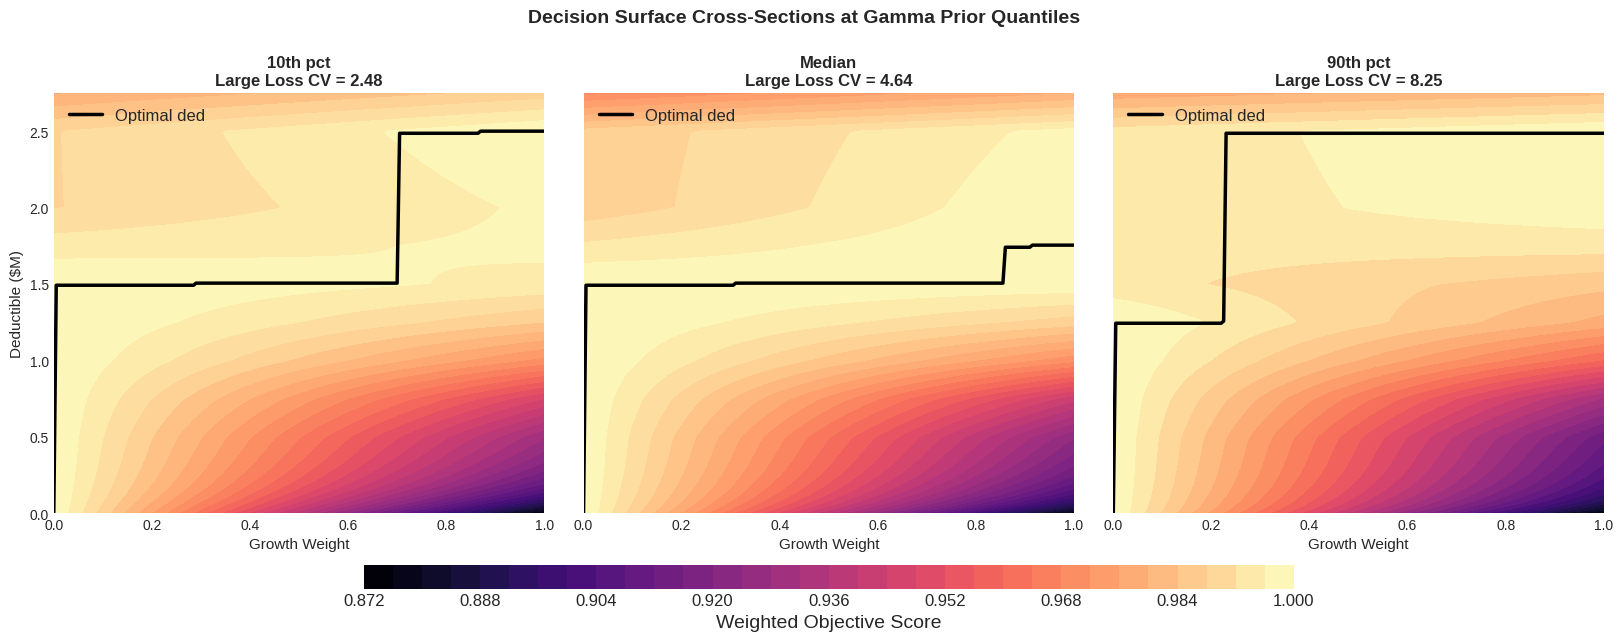

In [177]:
# --- Contour Cross-Sections at key CV quantiles ---
# Show the full score surface (like Part III's decision surface)
# at the 10th, 50th, and 90th percentile of the gamma prior.


cv_quantiles = [0.10, 0.50, 0.90]
cv_at_q = [gamma_dist.ppf(q, GAMMA_SHAPE, scale=GAMMA_SCALE) for q in cv_quantiles]
# Snap to nearest sample
cv_snapped = [gamma_lg_cvs[np.argmin(np.abs(gamma_lg_cvs - cq))] for cq in cv_at_q]

fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

for panel, (ax, cv_q, q_label) in enumerate(
        zip(axes, cv_snapped, ['10th pct', 'Median', '90th pct'])):
    data = cv_sim_data[cv_q]
    _s, _g, _r = data['s'], data['g'], data['r']
    g_rng = max(data['g_max'] - data['g_min'], 1e-12)
    r_rng = max(data['r_max'] - data['r_min'], 1e-12)

    ded_f = np.linspace(min_frontier / 1.1, max_frontier * 1.1, 200)
    gi = np.interp(ded_f, _s, _g)
    ri = np.interp(ded_f, _s, _r)
    gn = (gi - data['g_min']) / g_rng
    rn = (data['r_max'] - ri) / r_rng

    fw = np.linspace(0, 1, 201)
    W, D = np.meshgrid(fw, ded_f / 1e6)
    Gt = np.tile(gn[:, None], (1, len(fw)))
    Rt = np.tile(rn[:, None], (1, len(fw)))
    score_mesh = W * Gt + (1 - W) * Rt

    opt_idx_arr = np.argmax(score_mesh, axis=0)
    opt_ded_trace = ded_f[opt_idx_arr] / 1e6

    cf = ax.contourf(W, D, score_mesh, levels=40, cmap='magma')
    ax.plot(fw, opt_ded_trace, 'k-', lw=2.5, label='Optimal ded', zorder=5)
    ax.set_xlabel('Growth Weight', fontsize=11)
    if panel == 0:
        ax.set_ylabel('Deductible ($M)', fontsize=11)
    ax.set_title(f'{q_label}\nLarge Loss CV = {cv_q:.2f}',
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, alpha=0.15)

fig.suptitle('Decision Surface Cross-Sections at Gamma Prior Quantiles',
             fontsize=14, fontweight='bold', y=1.02)

# Add the colorbar to the new axes with horizontal orientation
cbar = fig.colorbar(
    cf,
    ax=axes.tolist(),       # steal space from all 3 axes together
    location='bottom',      # places it below; sets orientation automatically
    shrink=0.6,             # fraction of the combined axes width
    pad=0.08,               # gap between subplots and colorbar
    aspect=40,              # controls colorbar thickness (higher = thinner)
)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Weighted Objective Score', fontsize=14)

fig.subplots_adjust(bottom=0.3, top=0.90, wspace=0.08)
plt.show()

### Distributional Impact on Optimal Decisions

At each growth preference level, the prior distribution on large-loss CV implies a
distribution over the optimal deductible.  The **ridge plot** below shows this
gamma-weighted density at five key preference points, revealing how the decision
distribution shifts and spreads with risk appetite.

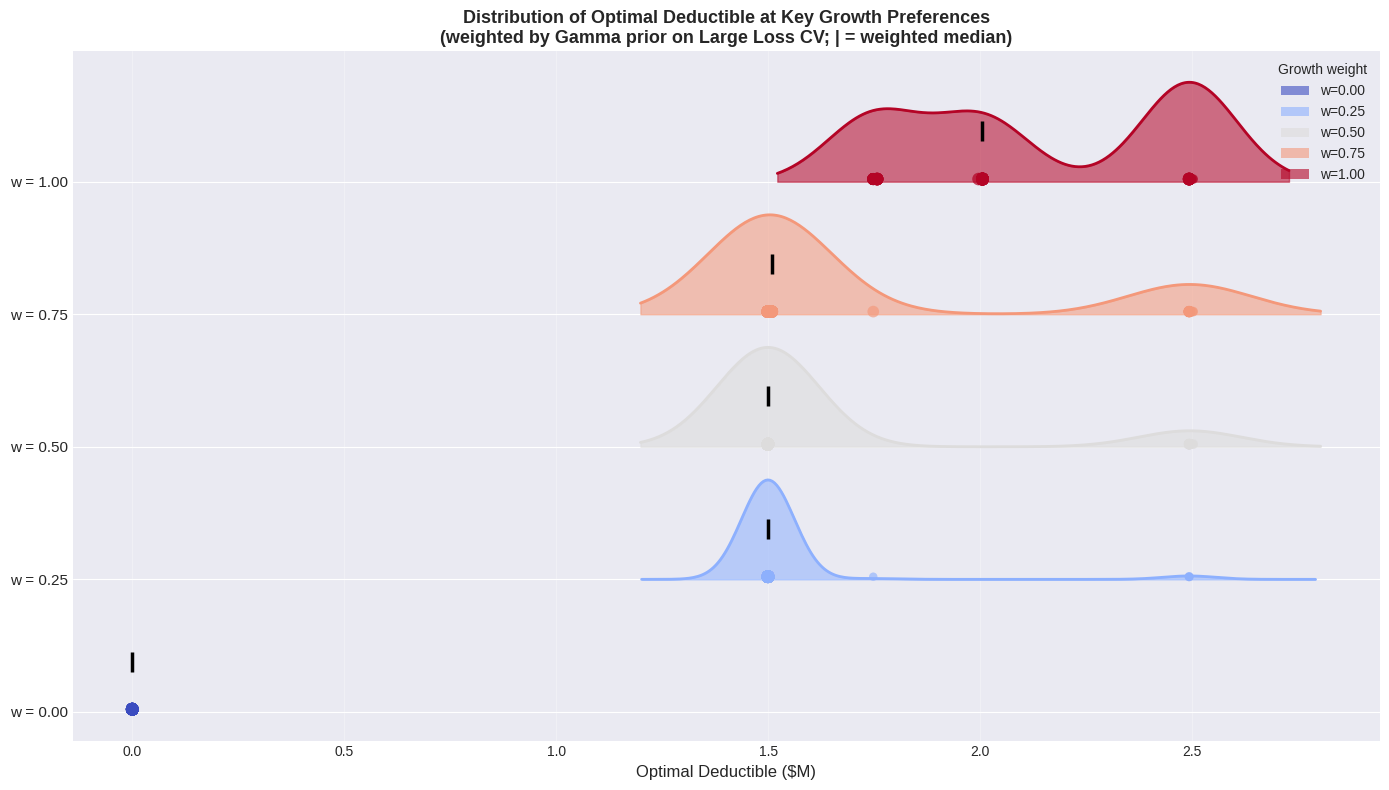

In [178]:
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch

key_weights = [0.0, 0.25, 0.5, 0.75, 1.0]
cmap_ridge = mcm.coolwarm
colors_r = [cmap_ridge(i / (len(key_weights) - 1)) for i in range(len(key_weights))]

fig, ax = plt.subplots(figsize=(14, 8))

for i, w_target in enumerate(key_weights):
    w_idx = np.argmin(np.abs(fine_w - w_target))
    deds_w = opt_surface[:, w_idx] / 1e6

    # Weighted KDE via sample repetition
    n_rep = np.maximum((weights_gamma * 5000).astype(int), 1)
    ws = np.repeat(deds_w, n_rep)
    if len(np.unique(ws)) >= 3:
        kde = gaussian_kde(ws, bw_method=0.35)
        deds_range = deds_w.max() - deds_w.min()
        xr = np.linspace(deds_w.min() - 0.3 * deds_range,
                         deds_w.max() + 0.3 * deds_range, 300)
        den = kde(xr)
        den_s = den / den.max() * 0.75

        offset = i
        ax.fill_between(xr, offset, offset + den_s,
                         alpha=0.55, color=colors_r[i])
        ax.plot(xr, offset + den_s, color=colors_r[i], lw=2)

    # Individual CV samples as jittered dots
    for cv_idx, cv in enumerate(gamma_lg_cvs):
        ax.scatter(deds_w[cv_idx], i + 0.02,
                   s=15 + 70 * pdf_norm[cv_idx],
                   color=colors_r[i], alpha=0.25 + 0.5 * pdf_norm[cv_idx],
                   edgecolors='none')

    # Weighted median marker
    si = np.argsort(deds_w)
    cw = np.cumsum(weights_gamma[si])
    med_idx = min(np.searchsorted(cw, 0.5), len(deds_w) - 1)
    med_ded = deds_w[si[med_idx]]
    ax.plot(med_ded, i + 0.38, 'k|', markersize=15, markeredgewidth=2.5)

ax.set_yticks(range(len(key_weights)))
ax.set_yticklabels([f'w = {w:.2f}' for w in key_weights], fontsize=11)
ax.set_xlabel('Optimal Deductible ($M)', fontsize=12)
ax.set_title('Distribution of Optimal Deductible at Key Growth Preferences\n'
             '(weighted by Gamma prior on Large Loss CV; | = weighted median)',
             fontsize=13, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)

handles = [Patch(facecolor=colors_r[i], alpha=0.6, label=f'w={w:.2f}')
           for i, w in enumerate(key_weights)]
ax.legend(handles=handles, loc='upper right', fontsize=10, title='Growth weight')

plt.tight_layout()
plt.show()

### Key Takeaways

1. **An ergodic optimum exists.** The deductible that maximizes time-average growth is *not* at either extreme: full insurance wastes growth on premium; no insurance risks ruin that destroys compounding.
2. **Beyond the optimum, everything is dominated.** Increasing the deductible past the growth peak yields *both* lower growth *and* higher ruin, a strictly inferior trade-off the Pareto frontier discards.
3. **The efficient frontier** runs from low-ded / low-ruin / moderate-growth to optimal-ded / moderate-ruin / peak-growth.
4. **Total cost of risk is U-shaped.** Some retention is cost-optimal even on a pure actuarial basis: transferring *all* risk is more expensive than retaining a manageable slice.
5. **Wealth distributions confirm the theory.** The optimal deductible produces the best median and upper-tail outcomes while keeping the lower tail above ruin.
6. **Preference sensitivity matters.** The optimal deductible shifts significantly as the decision-maker's weight between growth and safety changes. There is no single "right" answer without knowing the risk appetite.

## Next Steps

- [optimization/04_retention_optimization](04_retention_optimization.ipynb) — detailed deductible optimization with market cycles
- [optimization/02_sensitivity_analysis](02_sensitivity_analysis.ipynb) — which parameters shift the frontier most